In [1]:
using NBInclude
@nbinclude("diffSHT_healpix.ipynb")
@nbinclude("utilities.ipynb")

In [2]:
using Turing
using Distributions
using Plots
using LinearAlgebra
using Random
using AdvancedHMC
using LogDensityProblems
using LogDensityProblemsAD
using ProgressMeter
using Base.Threads
using MicroCanonicalHMC
using MuseInference
using LaTeXStrings
using AbstractDifferentiation
using Zygote: @adjoint

┌ Warning: You have Turing 0.29.3 but MuseInference requires a version sem-ver compatible with 0.28. 
│ Install a compatible version and restart Julia if you wish to use the MuseInference interface to Turing.
└ @ MuseInference C:\Users\andre\.julia\packages\MuseInference\jjAab\src\MuseInference.jl:44


In [3]:
#ProgressMeter.ijulia_behavior(:append)

In [236]:
using Capse

In [239]:
Cℓ_emu = Capse.load_emulator("weights_cosmopowerspace_10000");

LoadError: SystemError: opening file "weights_cosmopowerspace_10000nn_setup.json": No such file or directory

## Generate fictional data

And now we build also a turing model to generate random sets of $(L, \mathbf{x})$ coordinates. The $L$ factor is drawn from a LKJCholesky distribution function (for lower/upper triangular positive definite matrices) while the $\mathbf{x}$ are distributed according to a multivariate gaussian with mean zero and unitary covariance.

In [3]:
@model function Chol_data_generator(l_max, n_tomo)
    L = Vector{Matrix{Float64}}(undef, l_max+1)# a vector of l_max+1 matrices, each of them will 2n_tomo x 2n_tomo elements
    x = Vector{Matrix{Float64}}(undef, l_max+1)# a vector of l_max+1 matrices, the i-th matrix has (2ntomo x i) elements
    
    for i in 1:l_max+1
        L[i] ~ LKJCholesky(2*n_tomo, 1)
        x[i] ~ arraydist([MvNormal(zeros(2*n_tomo), Matrix{Float64}(I,2*n_tomo,2*n_tomo)) for p in -(i-1):(i-1)])
    end
end

Chol_data_generator (generic function with 2 methods)

In [4]:
@model function data_generator(l_max, n_tomo)
    C = Vector{Matrix{Float64}}(undef, l_max+1)
    ã = Vector{Matrix{Float64}}(undef, l_max+1)
    
    for i in 1:l_max+1
        C[i] ~ LKJ(2*n_tomo, 1)
        ã[i] ~ arraydist([MvNormal(zeros(2*n_tomo), C[i]) for p in -(i-1):(i-1)])
    end
end

data_generator (generic function with 2 methods)

Hyperparameters' choice:

In [5]:
nbin = 1
lmax = 31
q = 0#-0.5*(2*nbin+1)
nside = 16
npix = nside2npix(nside)

ε = 0.27/sqrt(2*3)  
N_noise = ε * I
inv_N_noise = inv(N_noise);


We can generate now some fictional data:

In [6]:
gen_data = rand(data_generator(lmax, nbin));

In [7]:
gen_C = collect(gen_data[i] for i in 1:2:2*(lmax+1))
gen_ã = collect(gen_data[i] for i in 2:2:2*(lmax+1));

In [8]:
gen_a = deepcopy(gen_ã)
for i in 1:lmax+1
    gen_a[i][:,2:end] /= sqrt(2)
end

In [9]:
hpix_gen_alms = from_alm_to_healpix_alm(gen_a, lmax, nbin)
gen_maps = Array{HealpixMap}(undef, 2*nbin)
for i in 1:2*nbin
    gen_maps[i] = alm2map(hpix_gen_alms[i], nside)
end

### Generate initial condition

In [10]:
free_param_n = (2*nbin - 1)*(nbin + 1)
num_par = 2*nbin*(lmax+1)*(lmax+1) + (lmax+1)*free_param_n

2112

In [11]:
gen_L = [cholesky(gen_C[i]).L for i in 1:lmax+1];

In [12]:
gen_K = deepcopy(gen_L)
for l in 1:lmax+1
    for i in 1:2*nbin
        gen_K[l][i,i] = log(gen_L[l][i,i])
    end
end

In [13]:
gen_x = inv.(gen_L) .* gen_ã;

In [14]:
x_vec = x_vecmat2vec(gen_x, lmax, nbin)
k_vec = vectorK_vecmat2vec(gen_K, nbin, lmax);

In [15]:
gen_θ = Vector{Float64}(vcat(x_vec, k_vec));

In [16]:
θ₀ = rand(MvNormal(gen_θ, 0.001*I));

In [17]:
vec_x = 0
gen_C = 0
gen_a = 0
hpix_gen_alms = 0

0

# Neg-log-posterior

In Cholesky coordinates, the negative log-posterior to sample looks like
$$  \psi(\mathbf{x},\mathrm{K}) = \sum_{i=1}^{2n_{bins}} \left[ \frac{1}{2}(\mathbf{d}-\mathrm{Y}\mathrm{L} \mathbf{x})^{\mathrm{T}}\mathrm{N}^{-1}(\mathbf{d}-\mathrm{Y}\mathrm{L} \mathbf{x}) + \frac{\mathbf{x}^{\mathrm{T}}\mathbf{x}}{2} + \sum_{\ell}\sum_{\alpha=1}^{n}(\alpha-2-n-2q)\mathrm{K}_{\ell , \alpha\alpha} \right] $$
$$  \psi(\mathbf{x},\mathrm{L}) = \sum_{i=1}^{2n_{bins}} \left[ \frac{1}{2}(\mathbf{d}-\mathrm{Y}\mathrm{L} \mathbf{x})^{\mathrm{T}}\mathrm{N}^{-1}(\mathbf{d}-\mathrm{Y}\mathrm{L} \mathbf{x}) + \frac{1}{2}\sum_{\ell}\sum_{m}\mathbf{x}_{\ell m}^{\mathrm{T}}\mathbf{x}_{\ell m} + \sum_{\ell}\sum_{\alpha=1}^{n}(\alpha-2-n-2q)\ln{\mathrm{L}_{\ell , \alpha\alpha}} \right]$$
The noise matrix $N$, which is in real (pixel) space is taken to be a diagonal matrix of dimension $n_{pix}$.

The index $n$ is $2*n_{bins}$ .

A Jeffreys prior (as said in ALMANAC) corresponds to 
$$ q = -\frac{N_p+1}{2} \ , $$ where $C_\ell$ has $N_p \times N_p$ entries; this means $N_p=2*n_{bins}$

### Neg-log-likelihood

$$-\log{(\mathcal{L}(\mathrm{L},\mathbf{x}))} = \sum_{i=1}^{2n_{bins}} \left[ \frac{1}{2}(\mathbf{d}-\mathrm{Y}\mathrm{L} \mathbf{x})^{\mathrm{T}}\mathrm{N}^{-1}(\mathbf{d}-\mathrm{Y}\mathrm{L} \mathbf{x}) \right]$$

In [18]:
#function negloglikelihood(L::Vector{Cholesky{Float64, Matrix{Float64}}}, x::Vector{Matrix{Float64}})
function negloglikelihood(L::Vector{Matrix{Float64}}, x::Vector{Matrix{Float64}}; maps)
    loglike = 0.
    a = Chol_Lx2a(x, L)
    alms = from_alm_to_healpix_alm(a, lmax, nbin)
    for i in 1:2*nbin
        d̃ = alm2map(alms[i], nside)
        loglike += 0.5*transpose(maps[i]-d̃)*inv_N_noise*(maps[i]-d̃)
    end
    return loglike
end

negloglikelihood (generic function with 1 method)

### Neg-log-prior1
$$-\log{(\mathcal{P}_1(\mathbf{x}))} = \sum_{i=1}^{2n_{bins}} \left[ \frac{1}{2}\sum_{\ell}\sum_{m}\mathbf{x}_{\ell m}^{\mathrm{T}}\mathbf{x}_{\ell m} \right] $$

In [19]:
function neglogprior1(x::Vector{Float64})
    logprior =  0.5*sum(x .* x)
    return logprior
end

@adjoint function neglogprior1(x::Vector{Float64})
    y = neglogprior1(x)
    function neglogprior1_pullback(ȳ)
        x̄ = deepcopy(x) .* ȳ
        return (x̄,)
    end
    return y, neglogprior1_pullback
end

function neglogprior1(x::Vector{Matrix{Float64}})
    logprior = 0.
    hlpix_x = from_alm_to_healpix_alm(x, lmax, nbin)
    for i in 1:2*nbin
        logprior += 0.5*sum(alm_prod(hlpix_x[i],hlpix_x[i]))
    end
    return real(logprior)
end

### Neg-log-prior2
$$-\log{(\mathcal{P}_2(K))} = \sum_{j=1}^{2n_{bins}} \left[ \sum_{\ell}\sum_{i=1}^{n}(i-2-n-2q){\mathrm{K}_{\ell , ii}} \right] $$

In [20]:
function neglogprior2(K::Vector{Matrix{Float64}})
    c = 2 + (2*nbin) + (2*q)
    logprior = 0.
    for i in 2:2*nbin
        cons = i-c
        for l in 1:lmax+1
            logprior += cons*K[l][i,i]
        end
    end
    return logprior
end

@adjoint function neglogprior2(K::Vector{Matrix{Float64}})
    y = neglogprior2(K)
    function neglogprior2_pullback(ȳ)
        c = 2 + (2*nbin) + (2*q)
        single_K̄ = diagm([i-c for i in 1:2*nbin])
        single_K̄[1,1] = 0.0
        K̄ = [single_K̄ for i in 1:lmax+1]
        return (K̄,)
    end
    return y, neglogprior2_pullback
end

function neglogprior2(K::Vector{Matrix{Float64}})
    c = 2 + (2*nbin) + (2*q)
    logprior = 0.
    for l in 0:lmax
        for i in 1:2*nbin
            logprior += (i-c)*K[l+1][i,i]
        end
    end
    return real(logprior)
end

### Neg-log-posterior

In [21]:
function neglogpost(θ; maps=gen_maps)
    vec_x = θ[1:2*nbin*(2*numberOfAlms(lmax)-(lmax+1))]
    vec_k = θ[2*nbin*(2*numberOfAlms(lmax)-(lmax+1))+1:end]
    K = vectorK_vec2vecmat(vec_k, nbin, lmax, free_param_n)
    x = x_vec2vecmat(vec_x, lmax, nbin)
    L = vector_from_k_to_L(vec_k, nbin, lmax, free_param_n)
    return negloglikelihood(L, x; maps=maps) + neglogprior1(vec_x) + neglogprior2(K)
end

neglogpost (generic function with 1 method)

In [22]:
ψ, dψ = withgradient(θ->neglogpost(θ), θ₀)

(val = 5070.85569166765, grad = ([119.06456467253042, 18.119071940605973, 30.440170301694202, -103.83171478316072, 35.898774677838674, -11.250019880400918, -5.834026580362799, 14.827843855425492, 4.970567017731473, -88.34002329748904  …  86.69383571427589, -3374.2064455211275, -594.6348994015785, -1982.5544630364348, -1793.6978157989656, 241.902560943377, 1859.8609353677423, -1530.4669228368225, -4167.8247489101195, -2517.802044601316],))

In [30]:
t_func = @benchmark neglogpost(θ₀)

BenchmarkTools.Trial: 1395 samples with 1 evaluation.
 Range (min … max):  1.797 ms … 10.577 ms  ┊ GC (min … max): 0.00% … 28.82%
 Time  (median):     3.045 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   3.566 ms ±  1.283 ms  ┊ GC (mean ± σ):  0.76% ±  4.12%

       ▃█▂▁                                                   
  ▁▁▁▃▃████▇▆██▆▃▅▂▂▂▁▂▂▁▁▃▅▆█▇▆▄▂▂▂▂▁▁▂▂▁▂▂▂▁▂▂▁▂▁▁▂▁▁▁▁▁▂▁ ▂
  1.8 ms         Histogram: frequency by time        7.51 ms <

 Memory estimate: 428.16 KiB, allocs estimate: 467.

In [31]:
t_funcgrad = @benchmark withgradient(θ->neglogpost(θ), θ₀)

BenchmarkTools.Trial: 603 samples with 1 evaluation.
 Range (min … max):  6.139 ms … 21.062 ms  ┊ GC (min … max): 0.00% … 17.99%
 Time  (median):     7.186 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   8.281 ms ±  2.224 ms  ┊ GC (mean ± σ):  1.12% ±  4.78%

     █▇▁                                                      
  ▂▂████▇█▇▅▃▃▂▃▂▂▂▂▂▂▂▂▂▂▃▂▂▂▄▄▄▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▁▁▂▁▁▂▁▂▁▂▁▂ ▃
  6.14 ms        Histogram: frequency by time        15.4 ms <

 Memory estimate: 1.19 MiB, allocs estimate: 2541.

In [32]:
median(t_funcgrad).time / median(t_func).time

2.3600893326326853

In [23]:
dim_params = length(gen_θ)

2112

In [24]:
struct LogTargetDensity
    dim::Int
end

LogDensityProblemsAD.logdensity(p::LogTargetDensity, θ) = -neglogpost(θ)
LogDensityProblemsAD.dimension(p::LogTargetDensity) = p.dim
LogDensityProblemsAD.capabilities(::Type{LogTargetDensity}) = LogDensityProblemsAD.LogDensityOrder{0}()

In [25]:
ℓπ = LogTargetDensity(dim_params)
n_LF = 50

metric = DenseEuclideanMetric(dim_params)
hamiltonian = Hamiltonian(metric, ℓπ, Zygote)
initial_ϵ = find_good_stepsize(hamiltonian, θ₀)
integrator = Leapfrog(initial_ϵ)
kernel = HMCKernel(Trajectory{EndPointTS}(integrator, FixedNSteps(n_LF)))
#adaptor = NoAdaptation()
adaptor = StanHMCAdaptor(MassMatrixAdaptor(metric), StepSizeAdaptor(0.9, integrator))

#metric = DenseEuclideanMetric(dim_params)
#hamiltonian = Hamiltonian(metric, ℓπ, Zygote)
#initial_ϵ = find_good_stepsize(hamiltonian, gen_θ)
#integrator = Leapfrog(initial_ϵ)
#kernel = HMCKernel(Trajectory{MultinomialTS}(integrator, GeneralisedNoUTurn()))
#adaptor = StanHMCAdaptor(MassMatrixAdaptor(metric), StepSizeAdaptor(0.95, integrator)) #(stepsizeadaptor = 0.95)

StanHMCAdaptor(
    pc=WelfordCov,
    ssa=NesterovDualAveraging(γ=0.05, t_0=10.0, κ=0.75, δ=0.9, state.ϵ=0.003125),
    init_buffer=75, term_buffer=50, window_size=25,
    state=window(0, 0), window_splits()
)

In [26]:
nchains = 1
sample_chain = Vector{Any}(undef, nchains)
stats_chain = Vector{Any}(undef, nchains);

In [27]:
n_samples, n_adapts = 1000, 10_000

(1000, 10000)

In [28]:
for i in 1:nchains
    samples, stats = sample(hamiltonian, kernel, θ₀, n_samples, adaptor, n_adapts; progress=true, verbose=false)
    sample_chain[i] = samples
    stats_chain[i] = stats
end

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter C:\Users\andre\.julia\packages\ProgressMeter\vnCY0\src\ProgressMeter.jl:626
Sampling 100%|███████████████████████████████| Time: 0:17:49
  iterations:                                   1000
  ratio_divergent_transitions:                  0.0
  ratio_divergent_transitions_during_adaption:  0.99
  n_steps:                                      50
  is_accept:                                    false
  acceptance_rate:                              0.5526114861540008
  log_density:                                  -2064.165652105044
  hamiltonian_energy:                           3113.814143733468
  hamiltonian_energy_error:                     0.0
  numerical_err

In [54]:
stats_chain[1][end]

(n_steps = 10, is_accept = true, acceptance_rate = 1.0, log_density = -2113.2047706014637, hamiltonian_energy = 3162.638248174618, hamiltonian_energy_error = -0.0027649683720483154, numerical_error = true, step_size = 0.0006578210975716682, nom_step_size = 0.0006578210975716682, is_adapt = true)

In [34]:
dE = [stats_chain[1][i][6] for i in 100:1000];
#dE2 = [stats_chain[2][i][6] for i in 100:1000];

In [30]:
L = 2*length(dE1)
dE = Vector{Float64}(undef, L)
j = 1
for i in 1:2:L
    dE[i] = dE1[j]
    dE[i+1] = dE2[j]
    j += 1
end

LoadError: UndefVarError: `dE2` not defined

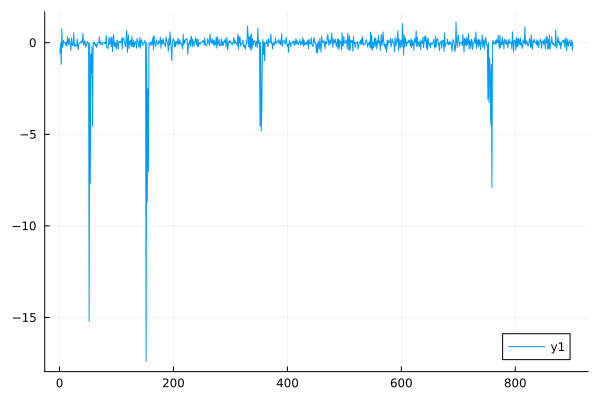

In [35]:
plot(dE)

In [50]:
c = [sample_chain[1][i][2098] for i in 10:1000];
#c2 = [sample_chain[2][i][17] for i in 10:1000];

In [51]:
L = 2*length(c1)
c = Vector{Float64}(undef, L)
j = 1
for i in 1:2:L
    c[i] = c1[j]
    c[i+1] = c2[j]
    j += 1
end

LoadError: UndefVarError: `c1` not defined

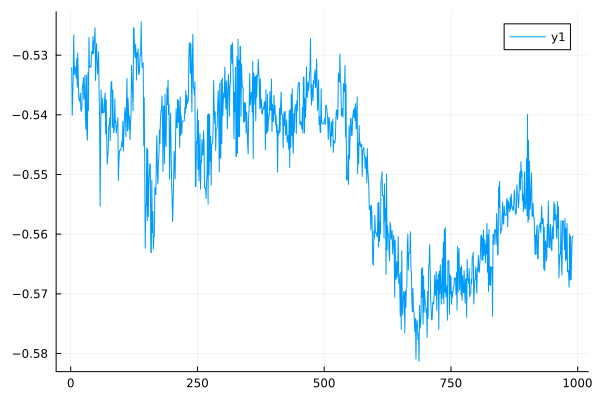

In [52]:
plot(c)

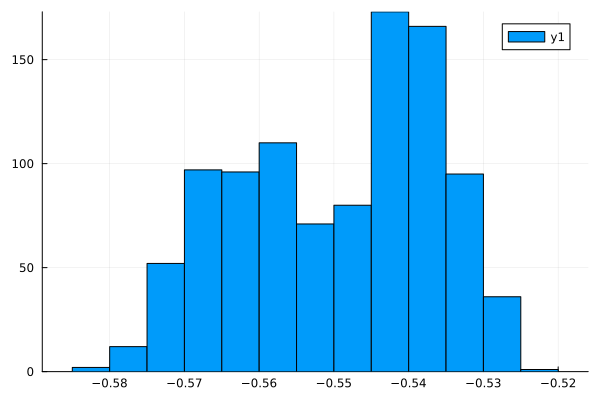

In [53]:
histogram(c)

In [54]:
gen_θ[2098]

-0.5910255308276013

In [136]:
lags = [i for i=0:150];

In [137]:
using StatsBase

In [138]:
acf = autocor(s, lags, demean=true)
t = 1+2*sum(acf)

-6.4964649551836935

In [ ]:
plot(acf, legend = false)

# MCHMC

In [23]:
d = length(gen_θ)

2112

In [24]:
function ℓπ(θ)
    return neglogpost(θ)
end

function ℓπ_grad(x)
    f, df = withgradient(ℓπ, x)
    return f, df[1]
end

ℓπ_grad (generic function with 1 method)

In [26]:
target = CustomTarget(ℓπ, ℓπ_grad, gen_θ)

MicroCanonicalHMC.Target(2112, MicroCanonicalHMC.Hamiltonian(ℓπ, ℓπ_grad), MicroCanonicalHMC.NoTransform, MicroCanonicalHMC.NoTransform, [0.7069835167122009, 0.7567879139628313, -0.5000208671051404, 0.5582565013495087, 0.5014107025530488, -0.8158270281608191, 1.0549249823719276, 0.16443883431202788, -0.25349632027951713, -0.5900987328126021  …  -1.915442159399352, -0.9890953311512461, -0.9330193748079931, -0.9193827303990387, -0.6998023175609803, -0.8679317490471681, -0.034099746746838175, 0.2567603682798665, -0.050092297189817975, -0.3087549100024757], ["θ_1", "θ_2", "θ_3", "θ_4", "θ_5", "θ_6", "θ_7", "θ_8", "θ_9", "θ_10"  …  "θ_2103", "θ_2104", "θ_2105", "θ_2106", "θ_2107", "θ_2108", "θ_2109", "θ_2110", "θ_2111", "θ_2112"])

In [27]:
hyperparams = MicroCanonicalHMC.Hyperparameters()#L=1., nu=1.) 
sett = Settings(nadapt=1000, TEV=0.000001, nchains=1, adaptive=true, integrator="LF", init_eps=0.5, init_L=50.)#  init_params=θ₀

Settings{Float64}(1000, 1.0e-6, 1, true, "LF", 0.5, 50.0, nothing)

In [28]:
#hyperparams = MicroCanonicalHMC.Hyperparameters(L=2.) 
#sett = Settings(nadapt=1000, TEV=0.00005, nchains=1, adaptive=true, integrator="MN", init_params=θ₀, init_eps=0.000309, init_L=500.)

In [29]:
spl = MicroCanonicalHMC.MCHMCSampler(sett, hyperparams, MicroCanonicalHMC.Leapfrog) # MicroCanonicalHMC.Minimal_norm

MicroCanonicalHMC.MCHMCSampler(Settings{Float64}(1000, 1.0e-6, 1, true, "LF", 0.5, 50.0, nothing), MicroCanonicalHMC.Hyperparameters{Float64}(0.0, 0.0, 0.0, 0.1931833275037836, [0.0], 0.9607843137254902, 1.5), MicroCanonicalHMC.Leapfrog)

In [30]:
samples_mchmc = Sample(spl, target, 5000; dialog=true)

[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
[ Info: Tuning L ⏳
MCHMC (tuning):  20%|███████                            |  ETA: 0:00:19

Burn in step: 200
eps --->0.006734763437661193


MCHMC (tuning):  20%|████████                           |  ETA: 0:00:21

L   --->9.662472335333922e-5
 


MCHMC (tuning):  40%|██████████████                     |  ETA: 0:00:14

Burn in step: 400
eps --->0.00048699923816763975
L   --->6.798582570193258e-6
 


MCHMC (tuning):  60%|█████████████████████              |  ETA: 0:00:09

Burn in step: 600
eps --->0.00044635504845978084
L   --->5.476600655933008e-6
 


MCHMC (tuning):  80%|█████████████████████████████      |  ETA: 0:00:05

Burn in step: 800
eps --->0.0004776581356651221
L   --->5.249061373250291e-6
 


2mMCHMC (tuning): 100%|███████████████████████████████████| Time: 0:00:23[ Info: eps: 0.0005353264385465419
[ Info: L: 5.365615003821875e-6
[ Info: nu: 4.258448847100468e42
[ Info: sigma: [0.00014009305805192602, 0.0005216737402702948, 0.0002874330029415608, 0.0003274481604378345, 0.00013547856858534734, 0.0006106644309595458, 0.0008922059663669751, 0.00043061599391634123, 0.0007396499211708812, 0.00025933635454471687, 0.0003851227946348812, 0.00026333380423671995, 6.025962717346022e-5, 0.0006408527943139233, 0.0002031967688914224, 0.0005459032898147574, 8.375073656491829e-5, 0.0010698678330911158, 0.00046961918454161805, 0.0007186474335743227, 0.0008335723822296063, 0.0005625878592796182, 0.00054929254167369, 0.0007335763621855706, 0.00037514186121458007, 0.00048237576815951885, 0.0006223335619902454, 0.0003204372287294143, 9.697176759634619e-5, 0.00025194246322458907, 0.0013444860572251842, 0.00037873568208812854, 0.0004177145189778611, 0.0004847906942368184, 0.001334321703085653, 0.

Burn in step: 1000
eps --->0.0005353264385465419
L   --->5.365615003821875e-6
 


[ Info: adaptive: true
2mMCHMC: 100%|████████████████████████████████████████████| Time: 0:01:09

5000-element Vector{Any}:
 [0.703485717518366, 0.7411860640924874, -0.5077815350819046, 0.5484682820735732, 0.5029846331227781, -0.8324272891302551, 1.0773389466225844, 0.160610632752383, -0.27389226105206776, -0.5821996806267685  …  -0.6759390471724024, -0.6971813590095223, -1.009280793531628, -0.1784937225917371, 1.041351618110089, 1.2681364751366109, -0.47258565589834284, 0.0005353264385465419, -0.03747368534095585, 719562.9007886068]
 [0.7034857177186941, 0.7411860588212834, -0.5077815371963352, 0.5484682866274627, 0.5029846334268788, -0.8324272936266044, 1.0773389594810467, 0.16061062897483452, -0.2738922420064502, -0.5821996797127014  …  -0.6759387334377942, -0.6971813531730415, -1.0092803925734632, -0.17849386454767938, 1.0413488143432204, 1.268148713740795, -0.4725860566096839, 0.0005373926329696051, -0.029640010907314718, 719581.7453554816]
 [0.7034857171188145, 0.7411860621239184, -0.5077815434295675, 0.5484682841948945, 0.5029846338624068, -0.8324272819793869, 1.077338967155

In [43]:
summary = Summarize(samples_mchmc);

([15.568930618056667, 11.225628685433442, 11.254007375360352, 10.735994925476309, 13.838904423676471, 12.496919879587942, 15.214803841751898, 12.971125446232627, 11.590655950921715, 10.923162205115839  …  13.117547962467025, 10.839055107327944, 11.157995443338963, 11.078235031923176, 10.571930796795263, 10.561152318742659, 13.544579918397911, 10.988965797006884, 5201.689680772349, 10.561152318742659], [1.076516526220723, 1.5764787954503179, 1.937520179644584, 1.9859160160643021, 1.4304357205328713, 1.2038491576807824, 1.07453545385221, 1.2172587704456472, 1.9257889794303131, 2.109217082480488  …  1.1131509023323083, 2.092218281027343, 1.7813076774847478, 2.115807798761919, 2.122990020607393, 2.122992308497388, 1.1217870576375752, 2.020247540824307, 0.9998168852505219, 2.122992308497388])

In [57]:
ess, rhat = summary;

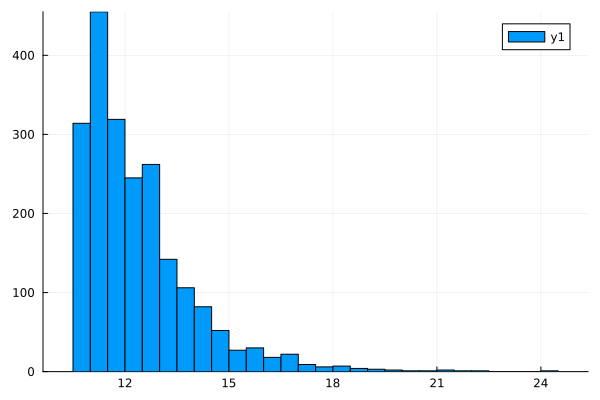

In [52]:
histogram(ess[1:2112])

In [44]:
length(summary)

2

In [37]:
s = [samples_mchmc[i][215] for i in 1:5000];

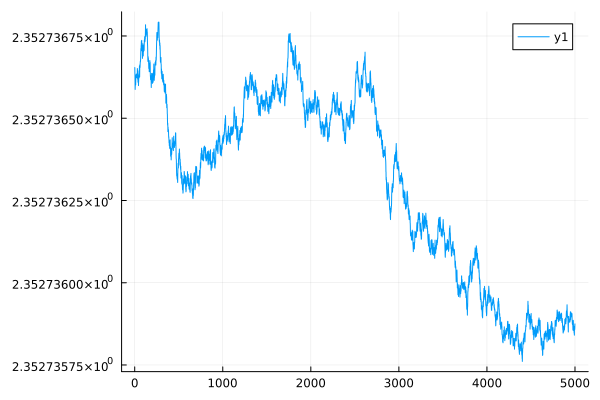

In [38]:
plot(s)

In [39]:
θ₀[215]

2.4345208910461196

In [40]:
gen_θ[215]

2.3739394453424176

## Testing

In [147]:
d = 100

100

In [148]:
C = rand(LKJ(d, 1))
inv_cov = inv(C)
d_cov = det(C)

m = 10 .* vec(rand(d,1)) .- 5.;

In [149]:
function neg_log_prob(q)
    return 0.5*((q-m)'*inv_cov*(q-m)) + 0.5*log(d_cov) + (d/2.)*log(2*π)
end

neg_log_prob (generic function with 1 method)

In [172]:
function ℓπ(θ)
    return neg_log_prob(θ)
end

function ℓπ_grad(x)
    f, df = withgradient(ℓπ, x)
    return f, df[1]
end

ℓπ_grad (generic function with 1 method)

In [173]:
q0 = rand(MvNormal(m,I));

In [174]:
target = CustomTarget(ℓπ, ℓπ_grad, q0)

MicroCanonicalHMC.Target(100, MicroCanonicalHMC.Hamiltonian(ℓπ, ℓπ_grad), MicroCanonicalHMC.NoTransform, MicroCanonicalHMC.NoTransform, [-2.6168576153068113, 5.339076582410549, -2.3608629744879073, -0.46215187191199014, 1.1398481630602686, 2.367828555930664, 0.9749875271153685, 1.2003310384719255, -0.13851078862938562, 1.738752088780804  …  -0.627289062481692, 3.952751217996592, 0.2670199075312567, 2.9307935196517505, 1.112391716238758, -4.57917098336458, 0.3024429560323124, -2.104356899330947, -1.784697211432178, 1.9046046476226763], ["θ_1", "θ_2", "θ_3", "θ_4", "θ_5", "θ_6", "θ_7", "θ_8", "θ_9", "θ_10"  …  "θ_91", "θ_92", "θ_93", "θ_94", "θ_95", "θ_96", "θ_97", "θ_98", "θ_99", "θ_100"])

In [206]:
hyperparams = MicroCanonicalHMC.Hyperparameters()
sett = Settings(nadapt=10_000, TEV=0.01, nchains=1, adaptive=true, integrator="LF", init_eps=0.5, init_L=10.)#  init_params=θ₀

Settings{Float64}(10000, 0.001, 1, true, "LF", 0.5, 10.0, nothing)

In [207]:
spl = MicroCanonicalHMC.MCHMCSampler(sett, hyperparams, MicroCanonicalHMC.Leapfrog)

MicroCanonicalHMC.MCHMCSampler(Settings{Float64}(10000, 0.001, 1, true, "LF", 0.5, 10.0, nothing), MicroCanonicalHMC.Hyperparameters{Float64}(0.0, 0.0, 0.0, 0.1931833275037836, [0.0], 0.9607843137254902, 1.5), MicroCanonicalHMC.Leapfrog)

In [208]:
samples_mchmc = Sample(spl, target, 10_000; dialog=true)

[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
[ Info: Tuning L ⏳
MCHMC (tuning):  20%|███████                            |  ETA: 0:00:09

Burn in step: 2000
eps --->0.06356739603324993
L   --->0.23471037987469273
 

MCHMC (tuning):  21%|████████                           |  ETA: 0:00:09

MCHMC (tuning):  40%|██████████████                     |  ETA: 0:00:09

Burn in step: 4000
eps --->0.0014911557848855301
L   --->0.0068363478258957585
 


MCHMC (tuning):  60%|█████████████████████              |  ETA: 0:00:07

Burn in step: 6000
eps --->4.7103475404870153e-5
L   --->0.0002053128829356235
 


MCHMC (tuning):  80%|████████████████████████████       |  ETA: 0:00:04

Burn in step: 8000
eps --->9.917646944465332e-6
L   --->3.989086217537732e-5
 


2mMCHMC (tuning): 100%|███████████████████████████████████| Time: 0:00:22

Burn in step: 10000
eps --->6.407376927740518e-6
L   --->2.3869792808671768e-5
 


[ Info: eps: 6.407376927740518e-6
[ Info: L: 2.3869792808671768e-5
[ Info: nu: 0.06155029117575803
[ Info: sigma: [3.0005638828940158, 4.1574426181576785, 8.955773232627127, 0.06088510692743457, 0.751679111824381, 5.997583541569077, 1.6876198452321856, 2.713916381934873, 5.96491178478116, 0.6860204773767312, 2.256791407020204, 12.572760391899813, 1.1592516700125597, 1.0986922604469314, 1.5893296879407457, 3.541174293090028, 0.5430947061824304, 1.5028377931527532, 6.063857537546241, 1.755921461636448, 3.269151922386292, 4.6544028862580875, 1.6185120395642012, 3.8766454301704925, 4.923054042613964, 0.3927006800578168, 5.678662496905267, 4.353149753500909, 6.22269210994614, 1.6462336975741392, 1.4117532836168278, 3.2285443265035765, 7.284268074219467, 3.933162592381585, 0.6695968793366381, 0.5643005056371306, 1.5017673652633339, 3.289180025336918, 0.3858003221537613, 0.2551313995958037, 3.6624574662748053, 1.3761812513602985, 4.431570438478828, 0.07252745905487602, 6.671289368416319, 7.28

10000-element Vector{Any}:
 [9.842572994775676, 22.29919832741376, 32.3062164191331, -0.6836249323704073, 4.345413910535831, -21.694990562298795, 8.047428742697166, 12.379858426616865, -24.00122669183328, -1.1661773654171657  …  7.355793198528233, 22.13651947274989, -11.259268892455946, 0.5979273545193724, 18.97245616680599, 0.37506754424287075, -6.339023139750622, 6.407376927740518e-6, -0.34018827974796295, 9.720516621395148e7]
 [9.842575249238527, 22.299201851698466, 32.30623293596243, -0.683624942207685, 4.345413615520668, -21.69499694824299, 8.047428594145291, 12.379859954000526, -24.001232025680597, -1.166177067724571  …  7.355792838850552, 22.13652216565874, -11.259269556019209, 0.5979273241185684, 18.972462046184805, 0.37506775106629964, -6.339022577568429, 6.424517562173102e-6, -0.24370960891246796, 9.72052127434067e7]
 [9.842577497084495, 22.2992040730379, 32.30624626724526, -0.6836249481616163, 4.345413271495446, -21.694999158791195, 8.047428844339388, 12.379861744562154, -24

In [217]:
s = [samples_mchmc[i][87] for i in 1:10_000];

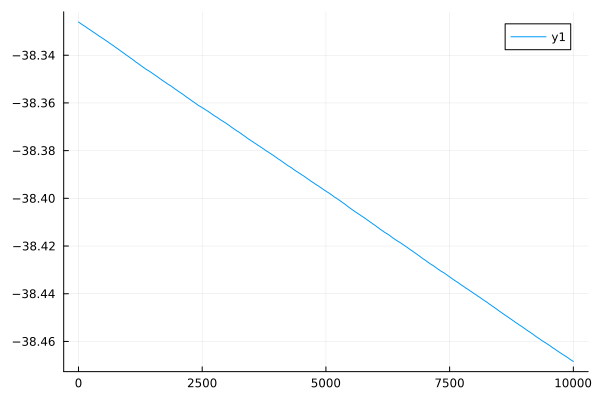

In [218]:
plot(s)

In [123]:
m[77]

-0.8543919901273291

In [219]:
@model function testprob(m,C)
    q ~ MvNormal(m, C)
end

testprob (generic function with 2 methods)

In [220]:
hyperparams = MicroCanonicalHMC.Hyperparameters()
sett = Settings(nadapt=10_000, TEV=0.01, nchains=1, adaptive=true, integrator="MN", init_eps=0.1, init_L=10.)

Settings{Float64}(10000, 0.01, 1, true, "MN", 0.1, 10.0, nothing)

In [221]:
spl = MicroCanonicalHMC.MCHMCSampler(sett, hyperparams, MicroCanonicalHMC.Minimal_norm)

MicroCanonicalHMC.MCHMCSampler(Settings{Float64}(10000, 0.01, 1, true, "MN", 0.1, 10.0, nothing), MicroCanonicalHMC.Hyperparameters{Float64}(0.0, 0.0, 0.0, 0.1931833275037836, [0.0], 0.9607843137254902, 1.5), MicroCanonicalHMC.Minimal_norm)

In [222]:
samples_mchmc = sample(testprob(m,C), externalsampler(spl), 10_000)

[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
[ Info: Tuning L ⏳
2mMCHMC (tuning): 100%|███████████████████████████████████| Time: 0:02:09[ Info: eps: 0.27523288959835057
[ Info: L: 0.26825679470457536
[ Info: nu: 0.24584219170901217
[ Info: sigma: [0.6534645052039028, 0.9305354136898795, 1.1416398132183792, 0.7774561619931638, 0.8795730207217156, 0.6744230303029641, 1.1862754121772068, 0.7507887552352448, 0.4876849049116214, 0.9773083308828528, 1.6443226372254116, 0.6927979185986773, 0.8906913971308247, 0.6512387899428262, 0.9864404270098909, 0.9969465552035397, 0.9980113495905862, 0.7895099664656028, 0.8885472578510933, 0.896239948928206, 0.8834556958721465, 0.6176792642073432, 1.07375125324529, 1.310599505468437, 0.9032951985967652, 0.8186347231017062, 1.0012111912311157, 0.9491468108885237, 1.026947831735532, 1.3713770308689293, 1.1148585515621012, 1.1189044139596962, 0.8379325687958733, 0.8318751684307178, 0.6103220270969437, 0.8612168699642184, 1.007696102683775, 1.3076205470177429

Chains MCMC chain (10000×101×1 Array{Float64, 3}):

Iterations        = 1:1:10000
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 259.62 seconds
Compute duration  = 259.62 seconds
parameters        = q[1], q[2], q[3], q[4], q[5], q[6], q[7], q[8], q[9], q[10], q[11], q[12], q[13], q[14], q[15], q[16], q[17], q[18], q[19], q[20], q[21], q[22], q[23], q[24], q[25], q[26], q[27], q[28], q[29], q[30], q[31], q[32], q[33], q[34], q[35], q[36], q[37], q[38], q[39], q[40], q[41], q[42], q[43], q[44], q[45], q[46], q[47], q[48], q[49], q[50], q[51], q[52], q[53], q[54], q[55], q[56], q[57], q[58], q[59], q[60], q[61], q[62], q[63], q[64], q[65], q[66], q[67], q[68], q[69], q[70], q[71], q[72], q[73], q[74], q[75], q[76], q[77], q[78], q[79], q[80], q[81], q[82], q[83], q[84], q[85], q[86], q[87], q[88], q[89], q[90], q[91], q[92], q[93], q[94], q[95], q[96], q[97], q[98], q[99], q[100]
internals         = lp

Summary Statistics
  parameters      mean       std      mcse   e

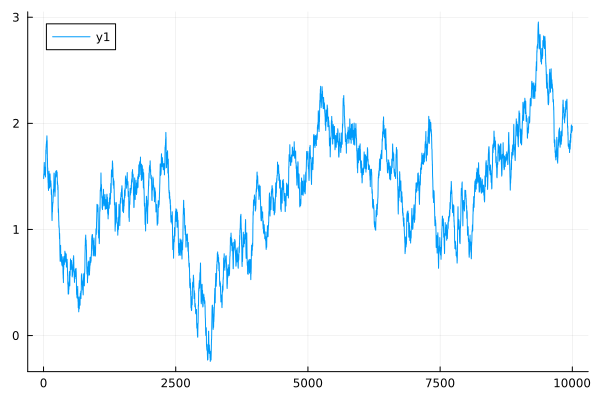

In [232]:
plot(samples_mchmc["q[67]"])

In [233]:
m[67]

2.0319430218090435

# MuseInference

In [143]:
x₀ = θ₀[1:2*nbin*(2*numberOfAlms(lmax)-(lmax+1))]
k₀ = θ₀[2*nbin*(2*numberOfAlms(lmax)-(lmax+1))+1:end];

In [144]:
vec_maps = Matrix{Float64}(undef, length(gen_maps[1].pixels), length(gen_maps));

In [148]:
hh = constructor_VecHealpixMap(vec_maps)

2-element Vector{HealpixMap{Float64, RingOrder, Vector{Float64}}}:
 [-16.148793743007094, -22.416066941126378, -9.811895991000046, -0.26147452548870476, -8.75427133977642, -10.039199373084013, -14.429204285922253, -10.79222765617968, 2.671782899221672, -1.8130827658683808  …  -1.1144437191027725, 5.358583631433383, 1.90477326802344, 4.107819330446045, 0.19520242526165899, -1.7303192539330525, 0.15076357230353032, 5.394624430540344, 7.387860845310061, 4.247187936622503]
 [-1.4623357068502125, -0.9428851987130438, -10.93126470065221, -9.156463183311622, 2.8052679643061538, 3.5189221401080957, 14.381016759717077, -0.09240947474870698, -1.1326936819319677, -8.771089879419304  …  -2.8705035364989575, 8.130898778063223, -0.00027936631570191217, 3.783898176258371, 4.37569061418584, -0.01984318392438933, 0.830160632565323, 4.037252053345802, 0.598077431340861, -2.041521914883792]

In [155]:
for i in 1:length(gen_maps)
    vec_maps[:,i] = gen_maps[i]
end

In [159]:
prob = SimpleMuseProblem(
    vec_maps,
    function sample_d_x(rng, k_vec)
        
        x_vec = rand(rng, MvNormal(zeros(length(x₀)), I))
        
        L = vector_from_k_to_L(k_vec, nbin, lmax, free_param_n)
        x = x_vec2vecmat(x_vec, lmax, nbin)
        a = Chol_Lx2a(x, L)
        alms = from_alm_to_healpix_alm(a, lmax, nbin)
        
        maps = alm2map.(alms, nside)

        d = rand(rng, arraydist([MvNormal(maps[i], N_noise) for i in 1:length(maps)]))
        
        (;d, x_vec)
    end,
    function logLike(d, x_vec, k_vec)

        L = vector_from_k_to_L(k_vec, nbin, lmax, free_param_n)
        x = x_vec2vecmat(x_vec, lmax, nbin)
        a = Chol_Lx2a(x, L)
        alms = from_alm_to_healpix_alm(a, lmax, nbin)

        maps_d = constructor_VecHealpixMap(d)
        loglike = negloglikelihood(L, x; maps=maps_d)
        x_prior = -neglogprior1(x_vec)

        return loglike+x_prior   
    end, 
    function logPrior(k_vec)
        K = vectorK_vec2vecmat(k_vec, nbin, lmax, free_param_n)
        return -neglogprior2(K)
    end;
    autodiff = AbstractDifferentiation.ZygoteBackend()
)

SimpleMuseProblem{Matrix{Float64}, typeof(sample_d_x), typeof(logLike), MuseInference.var"#97#103"{AbstractDifferentiation.ReverseRuleConfigBackend{Zygote.ZygoteRuleConfig{Zygote.Context{false}}}, typeof(logLike)}, typeof(logPrior), MuseInference.var"#99#105"{AbstractDifferentiation.ReverseRuleConfigBackend{Zygote.ZygoteRuleConfig{Zygote.Context{false}}}, typeof(logLike)}, AbstractDifferentiation.ReverseRuleConfigBackend{Zygote.ZygoteRuleConfig{Zygote.Context{false}}}}([-16.148793743007094 -1.4623357068502125; -22.416066941126378 -0.9428851987130438; … ; 7.387860845310061 0.598077431340861; 4.247187936622503 -2.041521914883792], sample_d_x, logLike, MuseInference.var"#97#103"{AbstractDifferentiation.ReverseRuleConfigBackend{Zygote.ZygoteRuleConfig{Zygote.Context{false}}}, typeof(logLike)}(AbstractDifferentiation.ReverseRuleConfigBackend{Zygote.ZygoteRuleConfig{Zygote.Context{false}}}(Zygote.ZygoteRuleConfig{Zygote.Context{false}}(Zygote.Context{false}(nothing))), logLike), MuseInferenc

In [160]:
Random.seed!(3)
nsims = 100

100

In [161]:
muse_result_manual = muse(prob, k_vec; nsims, get_covariance=true)

LoadError: Gradient [-146.50483196969273 -13.266578942352533; -203.36268905863017 -8.554028232850664; -89.01532810077777 -99.1704472588719; -2.3721450673469664 -83.06912091738378; -79.42036241601144 25.449907793800627; -91.07746625972074 31.924309954990402; -130.9043996107023 130.46723349525908; -97.9090775762706 -0.8383557797516252; 24.238906691062915 -10.276005761509875; -16.44862088078353 -79.5729433061738; 60.242357430742715 -70.93832408139755; 73.04268573468705 -41.7158126314659; -48.68358452663535 69.16162628807139; -91.28686074455464 18.075054376509723; 50.45794105189105 56.45235914616145; -10.281253083611727 213.67393624532468; -78.47266970905561 63.99701979318108; 10.763031683501328 -13.274909573167522; 101.31282549568199 63.55495589885091; 79.71678472245814 55.21954601941403; -27.355596449139146 -19.30472481168001; 27.686711159802886 23.47376099408221; 61.71912489164597 -65.28970148643168; 23.100975633889746 -10.714490186320116; 0.11986457046579825 65.65365208838215; -77.59499876953622 57.53798525211015; 18.961151318655126 54.897591318825214; 81.66861797011369 22.263062426788558; -2.3501179677822432 123.07258479994198; -23.78457142397069 93.13261682346159; -11.028314387931399 -63.27021936190676; 3.818151081146555 -13.744216465688663; 42.11759193452698 28.704329722814208; 63.48734500110584 120.92516015559289; 26.039097676988888 70.10595474006767; -16.52981229767787 -2.1009918188940273; 16.85897172819712 59.687844665146336; 51.19646940857391 46.89043454496178; -76.07076298370936 -67.07772264717009; -7.382821214177774 57.50446720039077; 20.508296041687714 -0.9039561291338851; -3.9442809493871955 6.155502515359427; 16.043923730491866 88.3370238629024; 81.34263690472909 107.68798274635066; -21.31669240482585 -67.30681913582345; -89.43486000844028 -92.71219017942676; 31.390621386965716 -9.0466829596362; 57.48673887366108 -47.56071409805336; -3.9436000171251537 -48.24262163637797; -66.17395842711012 6.740363262138367; -17.10555278250199 -57.30006023115979; -18.627096432320535 44.14676498261619; -42.77092282717099 116.32708427013692; -7.0680642238426445 21.772133307804367; 46.70867070233391 -50.371030710016015; 32.49551380249619 -56.42101299513151; 93.61501226691306 84.48791554060115; -48.419223774140356 11.09566566754775; -84.9241575963326 63.46539126735631; 33.514206078225 131.44333410717337; -68.35766964259444 -103.23553891635079; 5.395163055618203 -60.07526197724294; 63.36371466824624 -8.75377760647946; 81.6484186735787 87.59677663385304; 57.48376143101669 110.925425137745; -88.10328855210248 -114.39460467650132; -113.46882267646781 -197.92343011877767; 92.11872855306322 -134.55731354484044; 132.16070100355995 -31.10367711348056; 80.29193547716248 -30.619513554327494; -67.79482821390678 12.981223225277681; -91.53027389728744 35.22243139005437; 46.4826545385943 -69.89223690029398; 15.159350293163765 -21.608254771778757; -90.25529426755305 76.96759808624138; -108.96920534302295 18.40907652549089; -11.705324138681174 -12.246349599646063; 87.99785518679855 -66.02924861688267; 4.563694453272149 -190.1463445848602; 65.89038857937601 -12.23657836471892; 29.790407398657752 61.745322907707404; -82.94827097262225 38.31961512204526; 35.33051764300557 206.2299280704618; 23.139746116913514 92.16503044661015; -184.41625973029144 -187.43232137559528; -52.612682910986344 -55.23443225639449; 72.18777749000586 -23.12017791344821; 47.811528344835814 -72.63206668565077; 42.923951101408015 48.58461675631953; 25.51615844221684 55.948665706279264; -10.512143101203408 -71.98789455772818; -23.67515350375515 -71.10562080517997; 131.70892763986387 -97.35198153543523; 135.3775053480716 -29.920025832275307; 49.94129722585285 12.360843555025353; 36.31608326727589 -39.609153405771345; -143.138689405791 19.863018512259977; -68.63527854888633 50.60109304165345; 135.9179081202885 -10.761117217088593; 110.47486591322546 18.9893065251464; -37.72440475993539 49.91156898487912; -104.09995570115831 12.712696437251918; -102.97764745635126 -37.972783064660824; -29.528069028514725 39.04898903485584; 72.32190832231032 22.05815575396866; -47.099935104407415 -157.14935727386055; -15.163618667281533 -49.56020614284138; 28.00187527325926 76.10226216987213; -98.72850719951307 -42.91408121898145; -7.710261682307797 88.69646455271317; 71.69464947336981 180.37155045652642; -82.13867337628264 -77.44140152877571; -150.92377909129425 -181.7269124131423; -55.314164207357976 -28.358627809827425; 50.438150652157894 19.32487947851286; 0.7786541353381751 -48.554760208043604; -43.736757572711625 -78.73099684730748; -28.225991637653628 2.90640858862877; 25.71221361324467 -41.29513537570099; 108.2345802037047 -29.098122426081456; 39.55627532430156 104.71346126929954; 65.38949927750605 55.94936256509566; 71.95988302104435 12.129328849160002; -80.28255754957345 20.8011605879514; 14.00293599553197 -65.94896017757226; 17.899286083616875 -70.8945946052169; -153.8912881517877 25.581942934768644; -49.13858448092076 32.633890449760386; 106.39064675944616 -9.552573992276992; 112.32547819414886 62.496178323751174; 7.70037205929096 61.852580713029596; -66.20722625154151 35.40255252798096; -24.066522288657016 28.77495681483409; -61.30184031585783 32.484086586673; -40.06689971580757 111.67766891439025; 67.2881099675429 125.49731499245254; -24.86691859865415 -5.10590419065293; -8.21782387169687 38.66606208556694; 27.213525238010295 163.29041995394076; -118.42346353473373 -50.3264630878243; -93.86130020100336 -108.84289019651263; 39.72687932959226 99.30599347744473; -12.605942791463354 51.190013946977736; -125.53742689733393 -193.88138432983038; 17.8584563391132 -60.53184686491331; 10.967974521698272 -24.080320166515808; 24.29970023325056 -45.82389172042866; -22.89791692777828 -1.7785428508897803; -97.95996465686984 -20.930137985960698; -74.97804560833237 -16.868002743693435; -58.44167109445437 -42.976850235830184; 32.98165679983925 -107.03875002119274; 121.6482259221404 -52.47188523369662; -33.35248975751084 102.79867545854907; -118.4122623784646 111.08285853600837; -34.67622668043115 64.21640080101808; -110.51484441188012 48.91122396998177; -75.55057399947984 -79.75461747998823; 106.15692572605765 -101.88492606733135; 60.93813190143924 8.80721125651682; -60.20436925931548 78.16146231818819; -26.041293772236944 -12.31893412232693; 0.7604823470829364 -110.43612248057686; 45.97821871226156 10.135285244209033; 28.515565576035502 71.9812516822453; -74.02676514925157 50.37462106885737; -13.513749395293198 118.38839423422125; 58.2518389664904 137.13118799250432; -10.033135955729092 120.83034460795645; 4.620244804587593 100.84335861719045; 111.97563844859476 125.40970142386502; 67.89345273248621 74.47395335689755; 94.83314387904004 73.97221416245823; 83.58754999494047 238.13634567021936; -85.21929291462305 83.9514162403176; -95.84084665515587 -163.64000912423447; 13.985771384874349 -44.895556412260085; 2.040785139554617 86.58753689524342; -52.62828493563067 37.62616228273865; -8.718405512060832 -89.53719075051418; 100.81505687803715 77.76131340581696; 25.289644421920006 -14.352707152473515; -17.151515092370854 -137.0483509728716; -28.936930190026676 -56.629106580669045; -73.2576272029729 1.4412791236260363; -76.56732028075209 28.113535772503923; -53.55136216602304 15.79094741001219; -55.45784984634165 -41.82955347118434; 32.54858393570715 -41.03764582299791; 44.158299980991785 -70.86733177007515; -140.20010567911905 -26.81685483614181; -261.63835621290207 35.08294208796806; -134.9713426739354 50.202764248299815; -40.73068440481313 100.25706963025246; -18.07176016584366 -9.27115036425033; 76.7380811698181 -99.15191201673484; 127.88686484909064 14.255458251560217; 123.77663316452366 121.13799215110737; 74.50732491449011 114.66380210487765; 24.944550075141144 -38.39912650674418; -40.492723890159496 -180.17250645756388; 36.302401948230646 -57.04686660652213; 89.68399484738909 80.3642750063306; -60.225388084452895 58.84854829054509; -63.92186160583629 116.45533221569838; 46.05681777041275 147.41284662949408; 79.46156153874074 144.5831658072327; 50.77055522067516 126.91580925055189; 64.25906290223523 20.122206227102346; 128.86567574790232 55.11681222376727; 108.5510741229605 52.67003974289434; 141.6819954287636 -21.08322700126967; 104.92193896918563 157.58432927926322; -60.03589999118666 210.19351389739552; -28.02163128963012 -34.818086199560625; 70.91071578846444 -62.17227467919984; 49.83921518544434 38.99990774927128; -41.01397842760528 73.48455228583511; 7.976967699203332 171.58898141980845; 114.55988820068254 128.741223570315; 2.9528093666649062 96.33459826670178; -46.31831473072438 1.569229688883003; -49.406065578172836 -120.47259625877331; -19.962707679348405 -34.652082112781926; -2.100395772334358 -8.196512354985686; -20.08571986479923 -11.249298495151265; -26.589830464899098 52.603524031382996; -79.29523752988784 -9.201305667145379; -54.8257364211158 25.688228915564416; 38.24040531424824 115.39355645174389; -13.831165597599117 -31.040204404037183; -131.39868073511022 -86.93610224567084; -211.3142339958868 2.6718331747447057; -138.1230189040881 7.1701338930437775; 8.471703205755537 77.59733369647587; 79.00818745682737 94.41219151584326; 104.25607043289328 -8.183230088981018; 18.185874964420886 2.535412866328113; 17.465580991727016 71.73022588097808; 131.61509909367462 104.27903461403287; 116.86944623633886 79.4961042201228; 67.58978317469675 -10.640870830301923; -1.4880560079549063 -103.56590503136643; 64.8080271673623 -27.318986728955338; 147.66999252354387 107.00769177456752; -18.750776935054617 68.04417260158539; -73.10557594736785 68.16895157982239; 48.70232397960685 60.263002451323494; 63.10785066231408 -37.75484341489255; 75.89643002035753 38.781423860627186; 86.93825279541869 83.95545676939243; 44.83578457551124 -44.642695233856195; 54.71395314297319 24.97418071307959; 58.1053283167885 62.512352853727286; 71.10556463491363 -73.40939457264584; 42.35271689439265 28.49899986873074; -73.11097554787034 205.9047908345141; 18.626772005254352 101.99265843398697; 136.85496092509345 9.855026804886775; 102.28488821419457 94.52657396188431; 15.522044958383468 17.934440220196116; -40.25484387562966 41.08700604226491; 43.02448027226051 261.35859962521533; 72.84761815468033 202.0126348947553; -94.39236050649724 14.378213277766353; -89.3817459671334 0.13318724944919666; -34.760752507779415 -87.67265544668942; 15.316808594913796 36.97803381642983; 38.83187059060223 64.15524365821283; 28.71941946977919 -48.62074451299546; 29.707437048238013 29.627266165462945; -26.954315985024763 25.573996990851438; -141.42329864491995 -70.47749695708298; -42.58854973310629 75.65817433929315; 55.23178556790972 173.3580641565709; -27.498748688458974 -21.36819294841898; -56.84574180347354 -59.45179911006362; -65.14150893203067 64.3170255445399; -44.64822063427076 9.212589620560125; 43.034352888341765 -12.649413333055888; 87.02106528805128 75.05973134326142; 104.32766917711226 83.71849092728905; 18.304489382006743 47.595752477507595; -157.38134223343013 -5.871780173712923; -71.97475765397208 -33.0145903801623; 56.64507084666614 14.558467732092238; 33.18277466436736 21.07855296496796; 70.10992411043578 43.261427138287026; 32.932003067896666 39.20313512717146; 22.802821679226355 40.529493494846925; 94.74302385185968 111.13707791090175; -3.9957265342717143 57.1354681961366; -74.77106666080996 21.700032067933908; 84.44927794569156 38.23510621755572; 149.3758263050582 -122.54050382830707; 56.094806205996264 -222.43772155421155; 61.09271734489963 -25.928728882895054; 57.7955185664164 48.849111975886004; -42.048210481967764 -68.02490719062327; -33.7596183530922 40.94041919073882; 32.02578828036664 124.5140888966128; 3.3345665115394967 13.519795617703567; -20.289632281595452 37.60103065317846; -45.34384723866684 155.98502875562636; 55.85554784953484 116.95495465569583; 165.51862162216136 16.17193658599231; 78.23494374456641 91.04861874034955; 53.262486042865085 131.37490405685205; 19.21459436940589 -55.90544289919511; -33.70361072505498 6.800226605528243; -7.876070055420987 201.53082980654162; -46.59968729326674 77.24273974677868; -21.834627837346297 -18.660631958266176; -36.27824452755724 21.49754003435053; -13.111043266435969 -132.07516826053012; 37.5393651951051 -51.397141850106884; 22.13318837752955 54.78745311812176; -21.658139923405212 -62.03359514440451; -10.615173152156254 -26.69690193314029; 66.98214889371467 45.31726820062545; -28.942110347949715 -83.47227345786303; -130.16790272182806 -104.91533139907587; 28.36707167364744 47.406547680204156; 76.83478879317454 58.13120360747389; -44.41084367695089 -96.68583656405121; -68.28990054072365 -64.25160266243975; -57.74138358932724 68.85867510283505; 0.4584364306418004 5.988131697191735; 91.99052328196568 -61.20120334246365; 98.12382894521889 -15.800438903694126; 52.88619333445445 43.695375251053974; 44.30375113739181 72.42958597412073; -54.99721095660167 8.807481426105532; -154.39279523990965 -135.49452279925762; -49.05864216766706 -103.80750681799381; -31.976028649013127 16.0077533505963; -50.6485301667229 6.410991959320776; 70.70340482068379 71.91493864253408; 44.40989077666936 98.45584527135264; -57.69670599686177 20.954873512766646; -37.13738728443293 44.833999353765876; -21.052816344888512 21.610721096686753; -52.03875110704066 -7.149806354129352; 20.016452733124737 59.9404199275635; 169.75305268735707 2.8312816653200525; 144.49911421050385 -176.7558660370524; 14.114495973143889 -197.89432844931832; -6.572702518959587 -2.843354760724309; 3.9329002587668325 26.909462046428743; -75.46609941376694 -67.07115933654423; -44.159910445057974 36.5539170616824; 86.94687193506962 109.17558895754429; 19.89594026236862 68.05378068889226; -34.11865324538754 104.6942683722439; 33.56375668648992 136.89140045522277; 102.30956190598602 52.93758685440141; 154.7917333647031 -51.27290886549073; 30.610973798227118 -53.840293966144785; -28.377411745907477 74.09459370900343; 91.29451600779149 89.69657796228742; 39.65585946430353 -50.788433950469525; -37.83617251880217 29.57222367402347; -43.097657952395075 98.7496472055954; -53.604603799645346 -57.371168723567884; 125.79343240267403 23.19988117202582; 42.62519541505229 91.05046743185244; -32.93925944796044 -141.24200983033154; 8.372641030980907 -193.559422831326; -17.916940063517483 -69.2265024291485; -87.63691025209805 -109.61690691219194; -133.77410659660782 -96.27368510690053; -31.634166609265943 0.8273477252406543; 71.01364608995519 -90.69669345978654; -24.006539913908824 -142.79280039769216; -16.77342137993972 -32.67318288390627; 137.72894314592097 -12.033994712839064; 90.48683721857132 -81.18964843002678; -53.497122031656296 -141.21065817964293; -135.8547326655738 -92.50690807463316; -193.966894525746 -25.02226978624999; -67.97320401548728 -67.07590836668383; 101.08037578399052 -53.27801957946528; 122.96505849669417 -23.50813842714447; 62.26930095304882 -35.65748441151443; 13.783282864574916 -0.09648469532973021; 54.54385233693605 25.293731110761243; 32.88845678459714 -78.66682937301726; -10.179058371040197 -181.34589142127237; 6.856091659470573 -27.44967492062707; -55.341885955890504 87.88272557382531; -41.014295380015106 16.991428728153984; 85.1696146858435 64.05473097401257; 71.26649860552983 65.05470457190226; -35.51045697689673 -54.34578129459028; -87.55398695512002 -34.202515321741764; -49.60695748931173 -5.373484758354429; 2.7332343703226623 -6.283401930820787; -45.69514259038592 73.26458322367574; -25.173149991017308 66.98482007147366; 88.47058567520673 -0.1498297445121155; 60.46482259680377 -59.74630702243937; -82.98609326825908 -69.3777483495611; -112.31849880276421 23.982951127412075; 4.718531064246813 12.326045634603657; -10.053707175061646 -34.36729212856372; -33.637713871420075 12.52622688533976; 94.20459149434146 -15.705989862141559; 33.1171236992212 -43.64484159324254; -53.88655390669183 33.95763518866885; 63.09740685617944 78.49416661989468; 100.57446062070693 -4.671945547330112; 59.89597846314258 -100.57485370590788; 3.2522325632262703 -135.73275606267083; -84.82993955128514 -128.04392702214759; 14.861042432946299 -1.5628232943285087; 106.4123082469296 69.19316695060118; 4.985376527178922 24.95094293831004; -9.299319907988338 82.98072506919854; 2.0399911497294387 43.59179825895163; 32.945976102510606 -95.77133300665831; 167.41651134231162 12.235333670069169; 80.17922874414899 121.17990195678324; -42.20265978581231 -42.95086567727548; -9.061458687572104 -131.7226168502087; -31.618435436541276 -49.94195742174072; -69.97715567054733 -59.170345560872896; -107.9706003437698 -82.08710402669598; -121.50335917343625 -13.559735385636877; -49.40936527063694 -81.91687907166325; -45.706304293867355 -184.54439753828174; -41.51624323042416 -15.671994971120174; 97.62122289830307 82.2255997648794; 169.25851259655468 -73.0608658257731; 55.32283677056365 -118.03945779219043; -18.63405584441065 -76.30110503877103; -91.27227993279293 -54.409533406003604; -231.8682402417431 -51.59863772609591; -107.1941830732362 -108.9711763631071; 85.00951576612314 -50.44711551321981; 60.73047018932438 16.280464676760868; 50.11886495223334 -48.41258659110255; 16.79488179669916 -55.41182649915641; -7.198630792803898 -10.46371213170088; 88.90111567895475 -0.9480880125677653; 107.07546522352933 -84.30478797558634; 45.991883015058896 -112.86681380721828; 0.14130300998332823 44.58820562428438; -39.91637416790378 76.12633314671491; -20.226831389102756 -10.488775403873909; 47.667192375126305 29.4681363106364; 95.42374736310391 29.201543617093556; 94.72451886763925 -46.5782390509407; 2.485916797172543 -17.056157816962095; -73.56056248505514 1.636198472089657; -11.833332720590779 -8.137730752482106; -32.24077886298584 84.93097013541777; -156.68500397080484 51.158883483447056; -119.65215811923791 -60.41593634734383; -1.0156939548481752 15.331666191466816; -7.7586030515664755 46.73118819214124; -158.27788318027243 -7.6184059165909925; -176.22983677189592 7.498404982363277; 52.752285478027446 -2.645932302025667; 61.89195631416538 12.49438339125592; -94.8982475482709 7.146072051332553; -35.12709447854062 -117.24779711110996; -25.637454361183504 -169.53686672388378; -81.85081327837855 -107.2213608903736; 32.36247024056199 -28.788675449562966; 61.402654439017944 -11.61695270510873; -74.07707783201387 -70.77536123273063; -74.11262651817565 -85.23581930447048; -16.13806868048076 -129.9673524313088; -23.529456862659206 -169.03298426587264; 33.7783108411722 -29.453883962512972; 12.985946024820256 58.446860388812595; -28.611862563195253 39.51594981707334; 65.91500274347781 71.69049886704434; 51.47129528784336 -5.229904265512936; 48.014940742849134 -119.5057127875566; 101.86370926182965 -59.18315880484764; 88.23414279976444 61.22347235030889; -1.5727372697098256 34.845503532337865; 37.47528214707247 40.156265202117005; -0.1072986754958023 109.0072446777411; -29.452459821141765 96.60207274652208; 27.47867155322844 39.61044980804306; 21.486971429281315 37.802282318015216; -17.460265013226376 19.73571595008575; -117.78919983447412 -109.12117923327948; -167.76285715199614 -84.42238362747881; -11.889182934297077 138.28083960703216; 120.63832563615827 74.67436233055064; 54.418883556077546 -151.1212917566046; -59.65334677837898 -102.44689955516385; 5.070310596207342 -23.146577041796224; 63.50916676829541 -11.887469905237388; -78.67369241806398 50.54472995739592; -30.591612598970816 -3.770729264135509; 114.35988189445364 -39.75922505334025; -22.422085797890308 6.926179648042917; -75.07888115511805 -44.91425886235637; 15.73792642424862 -36.933304137072525; -47.66016356583027 22.019399721599324; -56.786647263712176 21.36342256666659; 56.52528703733617 28.25356624415278; 67.85597633173833 -33.224996408095514; -8.321520234271942 -61.44829866114439; -46.47787716504797 -1.9385895353348324; -53.95339392289368 -35.355536744293566; -85.66157982437002 -74.1415051156326; -57.009551995291325 -32.0444280980079; 81.67762431534804 13.728809720211856; 177.79761642812863 59.63630199761246; 99.45973862085827 88.42174832709033; -62.1081957515999 21.73496299575512; -87.67790716854986 -53.990099478017875; -27.372697906377816 52.74750052828553; -74.66715139853618 93.57619805943432; -134.07983907909392 -118.9773477441144; -101.34697929831884 -147.0138586315339; -9.01933133474459 47.6260428764009; 33.804236303040106 69.8364253840786; -122.19570281556315 7.505237683871293; -169.29445805542318 -13.404463794874502; 69.88462681956676 -38.72140238493812; 67.65509440551308 7.784437001019308; -156.48941861001856 2.5963602475738523; -147.21820486304188 -104.85283037479103; -56.923556892221114 -122.05469447118575; -28.941315598509615 -95.76560458620847; 48.36436659710758 -53.814467267254315; 70.46663336507254 44.59611362875007; -84.08721972421111 34.85220385793196; -158.03528565075393 -10.885277908098812; 5.76659596264007 -5.230308949868587; 55.40773557173886 -102.36865163438584; -20.982295523463833 -118.09745857270867; -1.1457841962477733 10.176691596981769; -19.590615647184162 7.787232714308703; 18.59685109012068 -22.249228188017135; 133.5248699849981 24.549285154255347; 38.06811991424926 -43.158734211757846; -34.83550029351381 -147.4657642918957; -46.86604518880501 -85.83022163591785; 84.96349943524667 -5.3655886581094; 8.445053830697825 9.15420554518867; 19.175677943950923 40.918333657566045; 49.54848888875096 121.07469599098452; -24.299769651489108 99.130728925808; 40.121147090242445 51.917416258286444; 117.4631309888092 16.30411004680022; 135.5872114584529 22.232683567054043; 44.180021619600026 22.41672750512728; -139.5108239891165 -64.76429210683908; -43.73340571198533 18.525015095603926; 116.06772914245273 110.7261605720977; 20.716155540235494 -89.25120362779741; -135.26791166728174 -150.17236252958264; -144.72736560240907 -46.12229070348707; 75.28708349522715 -87.84500769322185; 139.62820586604118 33.21118457481456; 13.04936202957656 168.99982921909748; 92.12732197104003 34.195873240779086; 35.00015067980386 -10.10082082043348; -152.19556441014078 -10.433777162953513; -56.41577269740003 -15.650793634795354; -3.4159823014152186 95.26926762994964; -105.37980075285934 85.61782766346896; -65.2207644644392 58.24065773126321; 37.05465761196862 63.421175334756484; 26.563586181624814 -25.10536446634018; -32.54995242620002 -56.84526352179654; -44.026939211575296 -83.30343229639563; -112.0357359385597 -107.72225019941612; -178.718413298774 -92.4484546115894; -29.684367635970023 -68.88557115036062; 127.64314171261186 75.23156657400382; 101.49917410096894 170.177066607432; 10.464780499887443 63.681186475751595; -67.85521277631096 -89.12105193397637; -49.1258582558296 -66.70914052509019; 36.84589195471591 94.01030924785002; 38.801300507985715 6.903725117133271; -45.26189529901863 -178.1203203914988; -73.6055776079349 -55.43860623351562; 72.85573984535063 94.88888968879834; 124.6798088083179 75.21978113082396; -91.02157464949417 43.91007635308374; -90.07194633047777 -41.59013658161595; 71.18157147330376 -89.1942572137689; -35.74526793645776 -30.737790273815484; -108.43448547212991 -30.83917771477709; -17.35335200072821 -7.4561990911211025; 68.65492264777171 47.197198917323064; 122.14564726169985 26.681818545938068; 109.30966644447966 86.84417456739243; 38.53229124998502 134.54113819925507; -106.25430731831574 23.364034110952225; -78.12440028875149 13.746232341088099; 47.93281614683428 12.956959995621187; -54.4476596791683 -69.96549541744169; -37.5860633546446 14.523303576239991; 86.89290582868549 33.7686888627792; 55.5977682907649 -60.35420211810438; 113.37527967521599 8.777374070503443; 109.17693106753929 59.14295349856975; -83.44907130656581 -48.12256202600792; 3.1058742017727723 26.064948603235848; -18.08201072541999 4.011530431846048; -131.5447675157511 -51.037667092315765; -24.55177072579084 15.795924125674194; 1.4931288340712139 -26.79510177837569; -1.6394739585469476 -111.24487592537233; 48.56201799399395 -107.35454236253568; 75.01464279463413 -123.0517423911388; 146.87287976428922 -18.57905494121651; 18.65277203378886 -12.97786770905831; -38.0404129245284 -133.7976135492329; 138.55479339003753 -27.281188604806008; 71.35589724649623 27.499754938766202; -70.20052864581615 -56.44793249748127; -146.62375808035506 -2.4338854908726466; -100.61979924174585 -61.24800218606639; 141.7417738830743 -107.53178364078016; 98.86831470529044 122.56662582664377; -36.65057764663977 107.75928309105531; 8.888714665286738 -22.230941599569757; -72.23071923255135 62.44845256974883; -92.38734772358191 48.78442928610415; 4.742978770038897 81.06759245888216; -27.568609617343046 133.32063430630458; -69.75813739162585 78.20191547546783; -6.103384355676859 107.13568005504267; 64.67697846928868 48.24530517532322; 55.500953064293775 -32.34896898811491; 33.87876568248613 -53.66500677673495; -17.11644194047043 -91.88898762232272; -165.09636162101577 -53.97532458067643; -115.94126688258056 -93.58213407619311; 76.41366527881915 -36.063588890767974; 33.01099071697517 137.84460219623512; -26.47540106967526 69.36662569643602; 26.556092309944177 -72.71176220071943; 3.638694562532378 -113.31592257846711; 41.27086207813586 -34.416823131219246; 138.77185434984796 29.609700117276642; 51.089908202026024 -72.71480997265651; -95.0144607750765 -76.5603002723001; -33.500607464938604 61.01513614056326; 146.66219503964072 99.60199530207969; 86.67831133562629 85.48570919969056; -82.81953240023134 29.854097382765012; -20.3488742500769 -99.91997800260692; -10.479077151317679 -119.42939055228358; -18.24747778394959 -44.287453436393776; 83.82417573217383 27.790953393377578; 100.60854443444853 88.80193139237001; 160.88168879078495 90.18916034851613; 130.0730834695496 98.90660959586397; 44.88151342891996 128.91355016683508; 5.338371757508332 10.139811003171461; -88.6554376062835 -80.36601843558442; -20.561963557760226 14.519473847431234; -76.74483515369344 -15.401072840550373; -154.4942493604975 10.21815728794012; 89.61375060094646 100.7367487896822; 139.6395186663856 -30.232683158530065; 62.83455470941342 -20.61299402991457; 113.61278517171043 126.65092295552492; -18.481698675034206 92.42158066994052; -136.65764246663508 4.241370218622938; -101.98052738539221 13.496037276436097; -26.500321373108477 16.85370626013962; -206.39547202291646 -79.01800494606867; -208.42856035802785 -56.59024565400696; -25.02224915645124 -32.535592835473096; 18.751675373717095 -175.86539671123617; 25.829617145258165 -174.8271974089827; -34.02090152079638 -182.1889164727305; 25.467237434866803 -128.32890783823703; 74.0077747050633 -0.0005830901154605649; -78.64380765305563 -164.51067551981495; -9.28634426388497 -215.80579901539247; 46.14514472487649 7.966886987268503; -20.804687688289114 94.66452114103204; 25.533242269894014 90.67921176927558; -65.06548186209841 87.2744878316854; 2.5662453377855194 -28.564443502682355; 156.94969451225478 6.188813153388865; -19.431332934647717 68.26122094114275; -113.15495615095203 -76.07285844388987; -50.69169864682149 27.141937055375116; -44.55524216966609 141.6382525634902; -19.73584093306489 45.482629688539575; 19.229408510526415 69.61110448925949; 12.618268451652364 69.0381797449566; -7.622510613065873 102.81693313879923; 28.670688471466416 118.72782567058537; 77.86733128940273 -0.7944989629583556; 93.37498492745233 -11.200986115123865; 86.93986840184533 -53.60448917026922; -33.042835091063964 -46.1261798178435; -132.03970615647742 -18.393915403481923; 0.9985939840869624 -88.8943761023546; 38.21661840377643 24.660366176893856; -68.04162908253318 43.88640480183491; 6.215196517446408 -61.056169287538644; 71.46674255083109 -62.46466327768985; 21.675148440581793 -83.37126133316605; 116.87120565049122 -87.20882808111888; 112.15221111698081 -80.41777329012855; -96.82577377168317 -53.94820482281531; -100.89943121888591 25.322680701643744; 36.782147425065006 71.78444346602228; 61.3561046492869 42.18842649566184; -24.860980517712054 2.756724885700131; -6.961091251012108 -54.77183992646476; -13.38078077489877 -123.6724823721897; -99.4625738719996 -102.38428250320494; 67.04866623326892 6.629412913669785; 90.0830574821367 46.025335516738245; 32.148439028478144 1.0395617944114222; 128.88815160563985 59.455743845730446; 25.066670578498787 94.88359628148062; -8.742998842831874 -24.74313149341538; -31.765820205837876 -173.89800654787885; -19.436405845840305 -84.43444777809711; 30.206152058284243 28.856705958003374; -168.17005080959285 -11.416624490522512; -59.485431114493096 107.16646077584147; 112.10155409601867 50.63342274564351; -1.6937321267115757 -82.46574642363574; 45.39780867315825 47.90551782836365; 39.0407526915926 106.77192877944076; -135.84345223474043 33.577794316224086; -51.20546260424537 -46.14019963758526; -115.4575461709972 -73.50902221643285; -249.2079345522143 -86.59591093441053; -121.27189072344092 15.739726712691867; 5.974571151670548 -56.373849256221895; 33.65911644733952 -91.8866722355541; -9.07629958825333 -64.61884787861831; -43.17108520591671 -102.38010345881372; 50.21267285400316 40.57662398364874; -53.88653835893096 -67.54753971103648; -197.93773530681653 -255.55192926787882; -140.21192785835274 -76.61560601488907; -91.55325702433521 118.01975150567687; 59.01134626333763 134.14499960199637; 92.06025971007335 104.7970195389933; -26.515984571699573 106.0127041779287; 80.59749151453515 56.509552141865576; 88.86261777655832 21.57588565758089; -56.17583066496274 -98.96708434362019; -66.51256677446312 -104.58869819801846; -20.05713222323875 96.09089736170635; -28.037035846073124 50.497350678243535; 1.2614663896456895 -11.235968269429268; 72.72900539521227 28.44051494551574; 26.97847812611948 32.39581680917201; -15.360907294500562 123.8353097565052; 7.42057144303722 59.19865265592082; 52.04822142704252 -18.53940600944269; 91.27517460063973 -9.190892612805415; 52.44668140263023 -82.49189742652592; -46.78120171159813 -36.81989509744412; -72.95238192680752 -56.224663690698684; -23.013500542204685 -64.87559076619465; -19.185498125766497 7.185706231378332; -19.11235830434876 -27.518525169411962; 34.53536674925216 -12.129199323412704; 14.911113355143868 -31.838703327942792; 45.85374356783197 -95.55670302371499; 171.51408231940272 -116.74023842343584; -11.40260761878735 -59.924384082355836; -129.26937768263554 9.730942570879465; 10.96605478316857 25.002322325741357; 4.309704940485677 10.969362966771639; -57.88804855122608 -78.46283280276053; -7.109451264937554 -95.83340579588082; 85.93653866877854 -60.67278348816241; -92.4207675755121 -88.848541443225; -128.90012023505366 -52.354416575562695; 36.373037129229324 34.444286334795976; -123.58951813435682 -79.68765293627779; -31.38434641537078 -66.11776928583673; 107.85993608124865 96.80510791790554; 4.217132255074085 9.181174955835253; -8.687332303771539 -143.7816830031424; -11.115403005944751 -168.52783429764168; 164.46983123391968 18.565403758166315; 59.946397381180994 33.04769488624232; -108.217793335679 29.45592344415025; 39.07592629670954 110.23250287580898; -68.09266991346006 -62.121766834018416; -62.556659787899925 -94.18506541742383; 67.0600858818595 -14.560075784889987; -61.40218200355038 -11.900417080684573; -139.3479135200144 -40.91223811046872; -44.13132559981721 -61.22814386171436; -33.79977728703589 -64.77960609533221; -110.59880247732563 -61.78192743524473; -118.93057019899359 1.2861924380975447; -57.392015092539076 15.26435902157069; -28.540581412404443 -2.2358379993320088; -21.348141016939106 87.14763900648929; -20.007620439244906 -6.255715873687305; 61.61053302697992 83.21218359059402; 60.796391448125526 96.77434585780641; -106.88237927453177 -184.00857776575282; -214.14545173467104 -65.60477075295543; -167.47751377863966 99.33447896237011; -11.936718458914244 100.76757227913882; 83.23628655666838 42.11138969499566; -0.9333030662178621 23.96446697143487; -18.63379836133867 78.19320765206567; 24.06700805369226 14.494965131756732; 31.894765853713903 -65.89057874002408; 32.54552839670665 -115.85207863892082; 10.889971945243955 -23.71791914433989; -18.50344527219002 20.64485401283856; -40.51144288568012 -24.20504992966416; 73.35799345052673 30.157929322111055; 62.850234759888416 -15.666210811161298; -32.56891947909662 6.158884255221166; -27.621574842336127 104.31579742111526; -29.058107327829365 3.4167224231060085; 37.918356065217885 -17.963575908064364; 33.83886916974126 -44.888049252176195; 1.228373803516452 -103.41004331920806; -12.40478723971196 -70.81689812677008; -100.98991816862049 -91.60334900330416; -63.42294471706628 -52.32558704613487; 43.224292261220405 15.704354345094734; -5.761999510895123 63.01713639461827; -15.151344223722228 8.384016432196992; -6.533623041232103 -35.782595680828834; 137.12331495749396 -13.455875125220592; 163.04755012243538 -10.725023635388585; -63.91206430270188 36.73383282634448; -7.524580655957473 -14.797783562615738; 25.569392907167522 -20.20847404881486; -30.79278558400087 -52.63657152710794; -23.627441527588562 -120.27224365891468; 70.46747415280376 -18.906215630365242; 94.82423108846282 28.93859304339367; -153.12919812502827 -39.43188769697155; -90.03269676682268 5.752048295117863; -110.166572674005 -18.081685514046452; -244.25561908752232 -146.29151517204542; 66.08202723111748 55.76023439585686; 147.33799037229946 100.67397483571486; 56.80822817920321 -3.4973979048393264; -11.993365037862542 -62.16396687161862; 110.06856739322386 -34.41219076836549; 270.59019108511137 101.47395247985921; 31.38910820697772 -9.447667785886015; 47.06146821550943 34.352533458988205; 8.906631829841615 23.598793279907003; -136.02476446166702 -108.57693494390179; 44.58013942652627 -113.50129199304007; 38.67930647969587 -77.75536758439164; -64.34002836389203 -22.670633534604004; 11.799004260634952 -14.240653111551724; -27.54445147199255 8.352908841260213; -17.313748971091368 7.682760779011134; -43.09486920133328 -10.958462598177114; -80.97920528854041 -41.92557444217086; -85.503019028417 108.7082259924173; -91.88980808380866 62.924237662126515; 31.61529863083927 -5.206659176094041; 91.9432720530702 184.9359939844311; 74.55330388153772 -74.62880306201835; 19.903500222855136 -82.38367353311595; -74.12975273160608 167.49932382043824; -5.103639695680416 59.748419310430414; 34.79085267412472 18.25426986768994; -59.3143454609937 -51.428819340622894; -54.13984473139096 -41.33065698439316; -72.29655053909343 -41.609815755295905; -80.9847438525096 -81.41092244904515; 62.2029155565068 -30.133576160313957; 73.59157062860409 -3.111534300802436; 22.97243290817287 -11.467141607528104; -41.88046768733126 -12.317478529448792; 8.976861710649747 63.20493476767456; 84.56462477624987 21.69639090120071; -42.11110425782867 -96.71093017086781; -8.877451152269186 42.207748687476595; -26.81359676570326 100.91337911217767; -16.296860621733344 -32.35640223195277; 36.07265511295818 -19.346867961387858; -37.87811509965853 -38.57385893837119; 32.47337159307828 -73.10233710791731; -5.491770301499144 -78.44082546392531; -141.39853093134252 -94.55076847708837; 24.203933514699965 -21.79036787488134; 55.63515523119168 131.1344297155736; -45.48288627496893 88.22313763624501; -15.304997151129125 -34.4466491805814; 2.4610202500840956 84.958781930461; 167.76116797967006 113.30110137187843; 83.03199307209776 97.48632077095435; -1.0114175350318557 12.924526295889242; 4.9499228785907965 -93.27172400619352; -23.97113632273161 -14.425881847880135; 83.90804812265334 -28.627863878437065; 10.865195078516788 43.97341226983815; 87.38367730762752 144.04552470874492; 63.896076891705064 92.63983704306939; -113.8937935482031 10.281805211386361; -25.70594641606518 45.25274439989091; -191.7785458689348 -54.65236079991503; -125.68408027975269 -19.822276052415457; 172.5485896985856 138.49205536213947; 150.2960702614662 76.54323109366864; 56.56243463176715 144.11688941831747; -13.341602978838779 40.43289186007715; 191.8204925791863 90.90175065686246; 168.27803219064657 67.76919324067515; 55.88490598518219 -81.73722152129675; 162.05119125883195 9.599334360925146; -26.999776401603338 -26.449127512928772; -16.761616816076735 -73.42331765081441; 82.23199786554115 -90.5114654968235; 17.150874997907156 9.644046328572227; 33.15013129023291 33.75679221546752; 79.43119328546994 40.91327305849693; -4.835081417384464 46.18525835677224; -10.77019635734098 33.758020488600096; 34.566870612231234 -15.464845806482131; -34.82258585497454 -87.36297116266634; -46.261242916907705 8.945199620628818; -142.9726398469409 96.54026506749848; -105.06514108558648 -109.82012908981567; 12.237885891201433 51.7779997476183; 1.1257992734941729 63.52090497596996; 171.18963091541517 -162.13681371972686; 162.54000857306852 149.28306901258884; 64.5247802668921 108.40358484921973; 67.67843796750063 -34.03182089599315; -72.53899689445379 7.48336638389251; -80.67306428861787 -59.799382330506255; -10.336114124349567 -88.3000796925634; -137.58514880140976 -132.95128990672006; -70.90572051014439 -30.260313112646312; 38.59273179195127 83.92957432969095; 25.290266193102433 40.46725076017716; 27.085140881022955 -6.171656509348541; -34.89928176514204 72.07988021734367; 48.96175129229059 49.426527037720994; -20.290139385581416 -99.91765556401366; -19.94987940267063 -38.63805494760278; 58.63667547066394 165.12760239246535; -37.55863496496798 67.47434977696628; 46.412046594552564 -53.11526841640891; -10.454530806637438 27.089581622930485; -41.28499374925836 43.651240448703994; 68.89975438215001 -0.9180536670483956; -50.87016747149516 -61.266028068617224; -64.4890361219489 -96.13051467117003; 101.38324135132028 62.915202260020244; 4.316733579657439 179.11819828126644; -8.167523310942066 12.666021370124588; -85.32468467084118 57.46092060370756; -42.77197096995719 174.9136554064962; 86.42567985860718 123.43454480224965; 48.149516276197446 80.06282850958522; 34.18689448395738 -99.41975515800628; -132.97128346792562 -60.603163865907874; 73.80121830529484 41.38706827347313; 144.49313025562344 108.11386865304539; -61.604628729564176 218.64008001033008; 95.38552210756828 178.6811033855568; 31.921993804042994 100.29737793214181; -3.2964548483688536 38.30085770963726; 44.41661384638547 58.66588974544642; -114.26446125036458 -7.357507342649562; 26.458442177685825 94.7666418733747; 116.96480844166747 67.76699558831632; 88.34002772362363 154.33666447032343; 14.526667076146468 204.2735229330374; 3.2018688375419306 62.29779214818135; 137.6864393832594 129.89454701000957; 44.25454037337692 -61.54505749586341; 128.58684884576851 -70.20220735536108; 149.82867380957958 7.979340860267114; -8.98884209240639 -2.651848765927079; 39.46979575344047 -27.83388691463822; 25.322030604091463 -3.2768326677020836; 47.797406938928084 79.82586016481956; 79.26320448739548 22.20797324831912; -35.880269143581444 5.648555533733924; 6.800856441401819 -36.09588806660958; 51.16065517384576 -57.716552135155965; 54.68280438984864 -36.323415804376154; -12.599507504717744 78.4566530936013; -184.06850863392714 -62.31242294717722; -71.37815691202259 -136.93195622758626; -134.1151695311166 94.76991181559865; -45.728926977415675 -92.24344488660546; 195.48024499328352 -30.253994635433507; 113.17909921137922 143.59858663009024; 53.8058437883471 -64.43096213616373; -4.664128661898338 -2.060255292362646; -61.539010227663304 36.75192009831364; 72.53678748954181 -10.888741405831254; 30.393938959552788 -83.00304632018361; -89.57812018995855 -65.27691922047619; -53.257268078430585 59.96849637836733; -70.76814152879032 86.05882663232339; 35.28317872396166 -2.1227941986853804; 33.451590759537794 32.72723008099673; -6.304078661323224 39.2492262595335; 13.234431151631425 -110.31609537505074; -43.91476967632694 -62.12420761853857; 95.44156112562385 156.89048608166343; 9.983557328141432 178.22727469622535; -10.522667612464053 -0.11518203482945621; 39.517893904776905 -13.666489650670398; -58.70373053630483 111.1915487824993; -20.767661982606107 130.4944888960605; 18.997262787296723 38.33963255267571; -48.166854985149854 -88.03638378701599; 50.456503105049514 -81.81963348197405; 92.14418837040363 126.16936369852013; 36.83130556174938 118.95394372741309; -70.40146812579195 46.936864039693184; -223.17208292323159 127.59837128026051; -40.504464303472275 89.54464269578851; 17.092423690718007 84.49244228829966; 128.0567845597848 -2.1594835442765743; -77.0607610038513 -70.72006555768648; -156.58180838581873 48.75991326421672; 200.82842378820666 61.44846147715992; 10.999770737346026 198.87486181208385; -77.45226431562783 176.74925856081424; 84.91536967276917 125.92126112815913; 15.167982296095492 57.13862907012542; 123.72787414675985 19.86473297807046; 116.42384026446452 53.14389593652331; 1.4191185292724253 43.02358999827678; 10.580930276452257 71.40158112598057; -14.115493435063314 28.496277734598603; 55.658646981721496 180.8564719049919; 4.919086828457747 79.46992926345867; 14.656043590066439 84.6395028004713; 58.87509352139321 17.638113135950384; 6.518256852221395 -89.40556455167189; 115.47648482114428 20.005961411891697; 58.356564304382225 5.947649246559451; -28.946984099851864 2.781104380583053; -13.25825354594295 -24.113175026386727; -17.47806278554218 17.537070180810584; 55.778393737779524 12.489746794822743; 101.83812598044855 -28.151537462564082; 91.60559936855273 -9.318018400446853; -59.06993176705636 -79.29058080632892; 34.9199227611972 -59.58057987144471; 97.57658995014712 -7.510314290801339; 126.33650662854909 57.33478447643092; -87.79605527506702 14.061319218474376; -113.8407898531165 -138.36426289632857; -82.28881893677683 -10.77739299416025; -225.51359129236917 67.34770749850495; -59.96997313923131 -89.01923908242051; 19.493254527818472 33.62283227529409; -16.52403249466803 -20.258621703221444; 1.1924500799882864 -47.389864454682304; 11.164270004503194 43.31975535969182; 84.0088993264029 62.766646833228016; 153.77496604724558 49.054761465631714; 53.41655147621582 -0.6125122823645966; -24.29202406631757 1.0248943149958798; -122.2941109621241 24.939258032446016; -76.53020380886012 -10.453523015983905; 83.0422687529588 -51.95816561982568; 23.16693779943034 20.83260351549143; 20.895458378832238 -101.80973279887523; -32.67019319936049 -111.04572138356293; 32.34235372011035 123.75250037913636; 58.19483058752432 162.4607671608669; -54.27020675616664 53.87918943160047; -5.653472055203013 3.819958426969549; -40.413300774251795 37.25460010001578; -58.76971587454798 156.85565252167603; -67.67851905044502 130.9932029157033; -26.235573178407755 -7.6793744763049645; -4.388253123976151 -129.85797875961626; 86.30651735427092 -22.02237048029176; 101.3586741788671 129.33880786244904; 28.947978645241214 108.47663245409743; -247.73387839289674 85.78188829125071; -118.9756637862781 38.58367414811522; 11.076862448286938 37.61622602610685; 89.74403147157696 70.09773721304542; 172.09883381875906 12.359973810014935; -187.75757547146625 83.88897986451524; -2.0106889438419127 25.259885730745108; 128.44924743973397 7.120438251605709; -89.2059876277877 122.64192677145728; -17.631914761627126 62.852478221256405; 41.95520756100996 98.17866610251447; 57.53066050363377 -44.174205615904526; 202.68903289324263 -7.384232541359344; 140.9198181953952 28.20169615492985; 9.499227052772929 65.0397054048372; -90.0655098040868 40.19137342430849; -44.28137206434043 22.655058209237133; 85.80826729026288 38.546620252865125; -0.12315758611860407 18.034140112746332; 24.444151910774288 31.972556477930183; 30.52685926864483 -96.0231791480372; -13.523900946566869 29.021485803786017; 52.01299983327108 29.005389039143296; -39.65803546021199 -29.09242568781823; -78.09137436624779 -56.25418191224975; -42.95765122164957 -47.092799843810404; -31.12958334899283 -55.43440321055228; 206.13378663935833 40.36747135959133; 58.20653800076181 -14.970692791287698; -50.41480951958925 -44.15568822468166; 51.223701596274495 -22.257945108955106; 113.95954207433765 44.212842214391415; 31.949715888841304 18.543850204068114; -110.75849981993709 -72.45955856149564; 4.687198186944708 -69.6740353655147; -108.25597554928073 74.52637193354917; -168.92075716995038 33.069153632969496; -164.11350978179672 -56.22821884990562; -104.05238010623017 -27.686600103095287; -13.921368165383575 8.666727489717257; 48.439741242192895 48.84809238789067; 86.84233886254896 20.231723988347376; 99.17464594707168 77.09383171663289; 73.79120213715989 87.27299466320424; 32.23774340666561 23.004717096109193; -44.709035574932834 -59.02041434961531; -121.63053984454106 -35.67088133562504; 7.2761723001438305 -95.53021445760595; 59.07381052135269 -43.27212006781594; 33.6194712247096 -3.74599677367966; -7.820752854248721 -119.35202922311771; -59.70018638584221 31.29187456688998; 17.61555171240236 106.11997508677398; -53.87789575560815 -54.3827418833908; -43.9507377778137 14.055239485139742; -88.2547773965214 23.020174696475827; -45.84680413117914 37.107114823248494; -72.3529919077849 122.70068245992638; -90.87358698351272 49.02909396638921; -31.950581750990832 -64.99139073662973; -5.218390395064984 -92.91059927022974; 71.99300238826444 58.26047360495657; 117.56682478208457 121.16737769184728; -103.64771204389767 91.3498942159696; -173.00822599921008 1.0508375977783697; 121.22425167292728 8.69072482793245; 18.291754186566887 52.59049646970596; 227.3657942420927 73.18987710660262; 80.54805617931311 107.4752883769904; -97.54212020171182 99.12151495486467; 51.68376560520371 -122.96656987284157; -15.149597918553651 -56.92238360516216; -53.31019179098294 14.378709522829459; 20.040212579579347 93.05300462839489; 54.350802773476794 54.399757391865606; 104.77512794363396 -119.47154192642432; 175.5957556753552 -9.445509468493137; 72.20180247391673 18.613121369392818; -42.06444219334796 109.62351703314111; -107.65281575734983 25.454604566756412; 27.06144010205812 -49.24813875266607; 79.02974848610756 -24.932996767156954; -40.23238701494471 43.04011282999714; 53.60118786261396 -95.40687582548986; 25.714353138539156 -40.949925975952475; 20.378158022802463 55.32894504931789; 23.608433184864307 -28.936251170086845; -98.03998919360215 -74.0421414839171; -58.00772560287154 -69.70353145000564; -9.263119544737012 -46.1694576831926; 40.533902376605575 -55.658932789756626; 155.46500197828772 63.632381676532326; 210.56124583036947 119.36484861320974; 0.17195740470038856 89.28815572708396; -29.64247763322104 21.385781144569528; 25.219605881325325 -24.714824798150733; 48.40809017559002 17.037350147916587; -76.76982352141465 -71.54623723755905; 0.4508574160277679 -70.13411015445641; 23.730966637511873 -6.360373627577184; -28.922997491179284 65.31338900818713; -127.47433982827306 -2.446284823513735; -195.9114236404164 -68.47527123674413; -0.5344815100648902 29.91941324926136; 69.30354989423869 152.53988181939832; 91.96881147805978 32.416365249491236; 22.723608533830674 -16.560735970286107; -53.44702457409527 56.81044220126885; -71.69385159131944 53.660763063558186; -12.693322055005671 -73.80398841218988; -35.72018733635042 -66.82116235322559; -31.569990195300473 -38.35631079702717; 4.769531187515165 -83.3116251807655; 16.56818101200354 51.81727067044639; 17.324654460577364 18.28938826273915; -111.27975773257734 -54.322566529438205; -86.92426570190156 46.535959699633; -68.3816349313685 -124.77272650970879; -43.74576413431449 -163.82686110967055; -63.71104841594222 47.993647008513; -111.45557165079288 -26.702327643652637; 10.134993570004301 24.530764713675126; -65.31936215569549 31.40761242752921; -34.72192289726329 8.124269309776954; -67.65961982589998 -53.84474888580255; -28.576771828430314 13.92800002271458; 54.27779544431589 90.69007313030286; 97.49873494793142 72.4298286085163; -138.89682353890197 -19.510240129024243; 96.93625476244371 -20.2512632099423; 93.27871679417566 9.65144303561193; 37.51814641390118 11.798303981962139; 217.18790046662232 75.8072398632704; 36.22107498671789 78.75604597334984; 7.018889370669484 -23.91234481475163; -71.8528168327275 -184.9003656804359; -40.00739293798974 -70.48335205752709; -23.60549869555176 26.263297267007584; 81.43345987886231 195.06301041954515; 80.55062131879048 -25.015792316515967; 74.10031141658288 -88.84757729590811; 48.70357888078005 -5.6660662319012385; -12.285804755920726 53.38011964600569; -37.80825179256782 113.99764127438256; -48.14617888006228 -29.584449343032144; 76.96505814366405 -47.78288002870103; -14.791386298687947 68.44314655709863; -46.52141736723069 11.212778418733585; 84.5221862436455 -87.5466437616744; 73.1320190859579 4.805197324281767; 112.88679984564652 -19.458490463136275; 3.124605602095177 -22.254290829760482; -72.27784043568825 -44.366138688423995; 32.029856490472056 31.833346936111866; 82.14471746650543 -17.820749169806327; 142.45605722415766 143.24960472281697; 120.61434228642653 174.21606387519; -17.932958762845356 181.70137009825933; -38.86628385589588 -32.58116727204722; 11.995217742552484 -15.87611761690063; -21.21553572892688 -13.630491709929688; -23.189675696288614 -84.10037888467899; 57.1762521936074 -35.638798762247106; 12.076966241201173 -9.73902873655233; 76.66422729575402 19.214138145314635; -123.55340243274345 -13.17593358072597; -40.96398536063877 -24.830434153605648; 75.58102520472652 144.12405747763492; 76.8720586355012 135.3820534182198; 5.605429357491809 -43.061184540736804; -118.14233821703911 -49.972608744142036; -203.96102970341857 9.997705470726302; -123.25774891098713 -54.03169332098858; 10.603532857632404 -90.1612838247278; 25.375441950380292 21.540041531117836; -4.2198892260954315 -16.50015461668104; -56.73051745751081 39.14565113315252; 1.2330289794544056 123.14667358511883; -76.34348475802764 7.653040136000278; -167.9617892543376 -45.10691796197596; -90.0970006518807 -35.34280931193463; -75.01791522230155 -259.30851910301493; 16.718674171686924 -95.5380795712744; -91.4209135060382 0.5000858868128122; -14.5136971697437 -33.02462125518208; 41.290916700751424 -12.044462171635265; 40.731573149783245 3.228639299789684; -18.8039255246196 40.57636537233858; -65.11991919567858 -10.425520565118573; -51.892967681342384 77.68149633882169; 95.52360760287199 35.575191060485324; 90.99491932158851 -22.754267945184207; -49.30474667491463 -60.89532395297256; 106.69232722654499 -5.289888829696722; -94.30438269636348 -113.68015401754258; 59.69740547204644 4.364770184303584; 90.54612027292502 -35.50030923871237; 67.04941460808955 -22.462353256602114; -110.56593411003168 -49.92868903890248; -113.18785692616501 -121.7982907286822; -55.35793963671356 -82.22833400909641; 7.437581495465787 112.38045978673433; 127.5171256233519 198.7383727800331; 39.089225257767474 -68.26812430234423; -10.366703911984544 -16.355871076032333; -73.75583718061448 -17.784562416651077; -2.5754570766513236 54.394146875964054; -8.626119127269902 23.042700838054603; 19.90668124249783 -18.77059842806017; 56.434816340354 56.107241085595724; -72.6809161546076 114.98886672216295; 6.004308164388156 31.982072524161048; 81.65337655220692 -11.666137950489707; 145.9586641669035 -57.295291793859796; 116.856270097165 18.771212720653143; 1.434814451138103 40.7937431907367; 0.5560145588578098 100.46393006200684; 131.35944035099794 76.36422951368736; 133.16563685375218 12.016110383341154; 25.666895777372616 36.88073290071929; 59.21712834241365 94.76994149038762; 61.03045664660757 191.1681059866136; -23.34146482930268 99.30290897563556; -24.67381216148404 -62.73747079808185; 34.891793186319326 70.87686613393687; -9.65158977647257 -3.3333545666731466; 89.92943800181317 -37.65755429093681; -5.005844061185684 -14.614717389003797; 68.47150509379266 -46.108504411504626; 89.67319787954483 40.21763325718798; -37.370393969846695 26.420209979260086; 8.649008815233962 -1.725786645677219; -3.8418828229007054 87.64276456785494; 9.094770960979314 0.6238603351958184; -94.57715259588444 -93.55509017482501; -165.93113278084033 -67.42400204209929; -197.3131836858002 -46.36902985287601; -25.415254892741174 -97.62769845907758; 34.69220588590114 9.665368619354927; 55.49536923111845 21.410883055392503; -33.657687209094505 61.26818519546413; -78.38986391368964 106.58004856571134; -14.251356288618851 81.7828756892567; -120.25896570845273 -45.27847885577816; -99.38791448980405 -6.831636432574094; -75.17972468884275 -64.61632434926788; -22.5307190802255 -211.42762219342853; 28.453672048534322 -48.65967892840516; -29.589872692045386 -30.32605089673069; 54.03535117096666 0.23961428299181123; 101.42012070183567 -63.74525904873679; 119.00787800609379 93.34831819905352; -5.176024184915502 14.823420076015276; 0.42574213697757385 14.892509002662386; -52.4348080503926 27.217531337478242; 227.57013884130964 -22.59462127301186; 43.64152443770571 -47.967781461328805; -45.31040640934358 -2.89371592661776; -91.5609065784868 -123.32746923214376; -123.62598430123538 -113.28291211313719; -15.14425150731648 -7.1970911860283495; 21.914453508313535 -197.13021878269487; -56.93297716839444 30.053322998209307; -188.37731236231394 20.533004135727914; -62.23572888135364 -96.1969203447787; -110.1567189599686 -132.47047065889808; 70.3620517401683 162.71754656219537; 60.392870916453326 71.54003580999654; 18.680703234055244 -47.61979530410278; -90.96221530638537 -8.110943490950612; -64.47972160099167 -52.183253173125415; 33.144412859748094 -42.32567382334855; 8.083728648569648 -19.93517575364592; 88.73805813015575 58.22000385555057; 33.550690980826914 63.28016500420981; -19.35175174668984 133.26528759451804; -14.595116439312104 94.29042395291576; 37.86771482009946 -55.90002688686101; 90.94116681717911 -22.39387387580568; 39.8346759330106 95.47725409817293; 29.529827805151612 126.10089172613411; 37.216795522489456 160.2964737427007; 150.93016333431748 -33.40264484312586; -78.97244640133533 23.38641427369991; 39.7735111769512 7.1191962758106335; 28.14869916184069 127.47907651450072; -13.888969008165223 -12.155460618887547; 23.180431770131186 41.790740007971635; 33.78629592929965 133.1071085646117; 65.62878880216512 11.31658876798736; 102.50921229370569 25.443364602691638; -36.46215423338983 -39.10880101187633; 129.51515397221476 -25.97350037387355; 93.7383611422576 141.36737880130366; -1.1896760028803222 -8.872610229925716; -128.43142464356296 -84.39292867555366; -30.482352649717207 -59.20079667977715; -46.31651484784801 -83.71363231399755; -62.21063940659765 -103.76990449438311; -96.05931997816916 -53.71365791428903; -35.989624235880534 -88.01860272297164; 14.343825521009343 -29.712132186810358; 9.682632056368092 -34.509197941767276; 87.69430791881759 3.32194032957614; -67.05138136992451 128.0525280264692; -57.26519898732769 30.77052100151344; 25.036721889762532 39.075471040625; -40.585395751427406 -37.68063950873842; -31.54878071681056 69.84829850306255; -88.24828033448252 -74.32104498879976; 6.448654970354072 -103.79643514744575; 39.55185034121216 -45.113860189644406; 47.069213505248705 25.920648478791414; 58.56029372526602 -73.977062826644; 162.77107241981923 2.59744016197746; 93.31069970156287 116.70312067824096; 105.21670977154389 -63.400935762318426; -19.09510254268131 -3.190842194053988; 58.3787774314577 -45.96400241604829; 260.29690679197796 6.628623696762989; -74.38394522236347 7.245497266553173; -77.28819767326523 7.816714381241066; -114.28817614237231 -137.50008687657632; -88.76691712904459 78.14723426870484; -103.21078083134518 -145.15029983855123; -50.64865465320382 -149.0304188866383; -191.11966927914682 122.53568352611072; -38.577080160409736 46.62375835004589; -111.12646225730562 -173.67660410975756; -53.45703828763656 -124.95492006656889; 26.16910908969381 90.74807475235427; 33.396276924533346 -71.66419286536605; 36.09003726872287 -17.61038156180383; -97.73256932565486 -59.10610029048145; 18.59396135360029 -107.44383604663588; -3.6705437213758056 -125.01646434315572; 70.80583866040891 55.70356471441678; 121.43089101787582 9.809883320226843; 64.85940910780427 20.71102587260995; -19.50385227817133 143.8006232670846; -131.2129543437576 -13.093859616249906; -43.952825891077325 -71.00880675661749; -84.44791284992117 51.59818686040798; 33.46966854723033 77.5409678814494; 2.248606976809343 162.3747536149775; 27.87775200375412 -9.670191032843507; 28.791642971993845 -70.81643833626619; -74.51842336928141 58.703458249326175; -20.49054471601414 -34.04574863912076; 11.502185995200053 -10.061249170180737; 35.8231565141294 55.03979620255949; -3.236729292819241 -5.369225132990205; 25.88117063868581 115.52376467123061; 9.53312352240458 96.40268281692198; 109.97000693421138 34.8899883435647; 45.16703780282477 40.73403100656948; 25.89608135246165 -91.5094791242104; 152.56307104009903 105.138238247188; 116.86502859685132 135.03402131859235; -94.02940107800084 -94.70958938579012; -114.85216121805514 -138.51335464412608; 22.142410858125267 -118.33438871016024; -25.01308265040987 -87.41967177571098; 46.5056213140103 -60.13161448085942; 14.903226049786554 -59.503986739197806; 35.65056208659088 -76.57332660782689; -78.5324535436593 -52.69615971291799; 68.59083991591626 -165.25427859784944; 83.13354636761149 111.27458372601798; -122.16092696170176 37.208467335726574; 34.80478601738344 13.329459630129957; 117.68542958185635 53.738134202515695; 12.662799531193983 -7.82299606825986; -72.92295421374975 25.04671668415328; -107.67100371803923 -47.392963189979724; 11.560473110927632 -15.512208667361417; 72.1001801837612 -8.603554407364935; 57.02892086756977 -10.849101614092085; 51.2000660775425 -135.20393600571967; 108.5197452123006 130.61122538651998; 92.64627243033303 -4.510530331987828; 126.12562623703576 -57.5495456255056; -101.1048326644839 -77.73986912438413; 177.29718802697184 -20.908329460585584; 67.14588198339301 27.63656446862555; -95.94557794922078 62.70911787828227; 14.76619435791136 36.249936856480915; -10.65374795128853 82.53838170561644; -136.4068810066819 103.25041330780772; -98.10156466706152 -199.4678906367305; -141.7670417573241 -13.61192294955513; -46.6687815132221 86.13102436137818; 12.974697951441748 32.62556551991878; -103.88603018820429 -199.3677694187746; 22.25720494365486 -47.02018626354875; -69.40887035091872 -91.6221807261215; 139.19346429935482 -91.80154150061533; 3.310757953070538 -38.84917401303874; -7.975398884734597 -78.1310396171072; -5.985993608404673 -165.95522177073025; -24.84210278348151 -61.417765997871015; 115.83270040843112 80.65444697686036; 90.3163866511543 -91.12555424816324; 67.50628933846099 37.86607981958639; -145.1033000641144 -49.55658146427566; -148.1081041975761 -138.20054895935533; -164.9226090761384 -11.081701048579072; -148.2151484930337 -29.282223955989245; 64.69584302233623 56.21160861903504; -66.88983554390288 30.68918423008516; -2.7646879266520057 -102.18383784447946; 8.89263923549154 122.5338483396966; 11.48567963207273 -34.90924195163892; 5.990386487762426 47.08462885395884; 70.60791233831489 27.4919801896859; -39.26762525140758 -1.0452860814503606; 12.699672586038908 78.4319676574852; -15.60245451884255 36.03369766714094; 76.68894120353347 65.46340565996097; 36.07636371188111 -41.782620448318; 86.6940670347394 -48.19743227006864; 141.48446189813654 170.32159013731746; 97.25327767064844 37.294331989289645; -82.9368324101971 -40.06754914241847; 49.23865330164921 -123.3993559975226; 25.05139430845381 -76.11967648509496; 68.51014402469225 -27.082642121111334; 88.92809415044243 -5.676524944056285; 28.027319291262803 -99.15360091524177; -63.633077391185516 -53.39332299277033; -49.55674980104322 -182.09600348596808; 137.49699886371388 -64.75482779057555; -54.56454006640438 130.53984775780694; -114.58085473809801 -72.60811309939413; 172.41849352393962 121.46960170331212; 119.96183252329588 15.014068640508945; -48.69947102545345 -75.26649711434344; -139.29485899016592 -60.4386923422813; -90.6768960069918 69.08116952256526; 11.200714961564243 5.711060659029203; 99.82693845874567 -0.5617782568134645; 21.6163897692502 -135.43345984787175; -2.038918241638803 -18.759514154334234; 3.385294120956573 110.8131547724845; 92.93712815311486 -31.7599399524739; -58.66997039864335 -40.7193375809774; -99.07988910465808 -128.48745764803323; 80.90639297502682 9.380296070814957; -134.26167935814482 -31.567559914052456; 2.588966933292617 124.48286424333908; 121.9103202050947 127.72605184205803; -33.50057607293684 175.31128395787024; -136.64842580903706 -22.260629207601653; -50.89773579762385 -89.896629064829; -70.67431526451686 -68.48594735835081; 92.46427058222355 78.74932198616672; -72.6902309578488 30.593699524854927; 76.00439454381743 -64.64682821838753; -86.0117120397929 -71.80910350163325; 3.3645640943183355 -174.08463723190664; 167.54648126252636 -40.07958914690401; -10.093707654656386 -64.57625652527662; 37.66425244757877 -60.82802373652934; -104.21384705757613 -170.56993179324226; -2.1040291606710673 83.59132867442311; 37.679988535587576 15.550567348825565; 50.096050748884416 -30.88136322923604; -26.25474931543414 -84.02202187611957; -133.00973964469435 -275.63856836291416; -46.06634830130614 -68.94709145003692; -239.8097937789332 -79.30218425614987; -17.856634648209607 -89.49271676628469; 35.05466866239059 15.202592111959875; -53.813845978174704 -86.87397601718894; -22.423581114641113 89.47733892619156; 10.771360485393313 208.86635198003512; 98.26961055757114 56.00930621488088; -47.4514910288994 44.0801622331788; 117.46332074914105 69.7735798957699; 7.831315960531161 -38.640909968358024; -12.981809999423763 -27.064951616774042; 17.98974187248913 32.2186628598817; -54.31294860753443 27.195270494883136; 48.35582532312651 49.66437233127686; 68.7473215206377 -101.41184634564222; 33.95283610623099 49.1341153755333; 101.40458484986713 82.11786503460065; 84.01420475386202 102.03182689224543; 22.662318492497757 16.413190478391087; 79.8681949986775 -100.77450411915802; 38.92251832951154 25.635700657372208; 113.5175506648057 71.68205529400855; 8.833767630504333 -8.942494284980544; -54.33525008190892 -104.23351265563838; -39.74175116187046 -48.83115011346822; 75.66168097207536 -135.80323334243408; 15.35088236254143 103.13686319437792; -164.98146839879675 -59.03396085127109; 19.598068091942892 -6.087648799367698; 206.7449357411464 143.88569800833287; 19.07271154524984 -66.27777769798944; -119.03027104880977 -157.93475511029075; -128.81549592470358 17.137223417753745; -62.47774283392131 119.92102205795413; 20.543855184682595 -22.729674119037142; 101.82029069844582 -47.07278345457267; -35.07014284967541 -120.15957084670804; -73.61588446466483 90.37350249535638; -45.82681917174076 49.29236820037921; -28.691848968623052 75.60511190081601; -204.99917347622045 -124.32296048072915; -65.30291409013611 -81.5803349656317; -145.7931588392937 -81.00614616577047; -202.78168710129341 -58.611784026907564; 40.123483127062244 131.56414677188764; 94.06870819785618 105.19126843738425; -114.25439114568451 39.071570785065695; -26.860170344317456 -7.4045109303174845; -10.73548512123911 -83.87769674243478; 51.248914161507145 -116.7968263108733; -18.86021726661789 136.44499825781145; 36.57581852701492 57.9016182358603; 82.6628618052802 44.415976525490954; -197.24217052748702 -170.5817231705976; 150.7774051066831 -61.2071327614971; 73.77686165185015 -56.0317499717194; 45.470799793411274 -13.727368957405151; -34.20930312325712 -90.77858651491404; -129.02547264887434 -50.95167888140851; -48.97936903471488 149.8547408235831; -31.818102388720494 38.60934959412464; 18.98904879012554 27.79896390927957; -53.64745742764925 -291.7057309382339; 88.94275990021082 -160.75327870616672; -26.346301065941883 -22.265993082430924; -126.14604872427886 -147.28210880668712; 114.58553052165948 -27.864835740321247; 25.99302943362179 -73.80763892173788; 5.757145894807951 42.70451905886006; 57.15815234476966 47.16768177425921; 21.587518941889364 0.7438735669768965; 19.638042171350325 55.09324471326873; 149.9608251829361 -23.84037308780167; -57.740794650064686 -94.84214534214598; 120.35383526848558 21.153680862031635; -19.464391165765814 10.35672115808899; -38.30327650345979 71.63820149998689; 78.64408152990171 4.682301323171951; 16.26562488670356 -41.94015180733247; -93.20233805059327 38.37801225260524; 83.21530188414532 84.38426286381562; 35.96797788475457 170.63796446450277; 6.694460014711647 -103.234841574416; 47.63778779051814 -9.93801483095996; 63.220043069090465 127.18512425158929; 22.750719645098034 140.43616005600114; -87.15848843094838 -51.94513296906012; 5.056379285701049 -23.741952669919602; 124.11853715077004 20.130757157149436; 1.9452388879949545 38.92328116663312; -112.59986660957973 -13.137878430840985; -68.62676963083554 -171.11793805011334; 133.06514432666614 96.97187836618055; 120.02403725520652 92.17931154482906; -41.785068850194406 -58.21888434213452; -122.39259483792353 -106.21147196254464; -60.12000060009738 120.34828201686314; -55.055726550760234 34.73566455755223; 40.30234800199887 -0.6930059521395285; 67.40188217852514 -54.71585520263194; -51.42631772384641 1.775250956852724; -71.72746432981283 64.53824517076164; -67.50162329959448 135.4947373135989; -144.55481881968868 50.91415655390767; -135.2444761018153 -140.02033353349486; -69.93164787484179 -13.794265583704805; -275.39549967527176 -173.07890267836981; -241.14354064258387 -58.19213606963701; 13.791059674078568 19.010390498763975; 0.6307670130122387 -15.844815414460125; -88.30542028291259 -24.056003736223907; 34.52392694195646 62.78525738320927; -4.914709132368236 -137.91970287589922; 13.766260330322485 2.774415644517535; -47.30618479794588 70.63188370524735; 156.00339439474405 92.35615689160954; -159.28318850966815 -30.343055476137252; -82.15646111429236 -111.45112984068275; 161.7307205619878 12.255838516864; 40.9775918150383 -70.6146931092216; 57.93760686175574 27.818498084629702; -75.48296808809562 -97.78921737747223; -122.58894737218347 115.84833471858747; -75.08603846344731 104.44651124534708; 15.756595242907034 122.85457823408439; -16.616384325703105 -69.0265497628741; 72.65651317097553 -169.4102325521392; 165.75843778507843 71.30768558634418; -30.4474867465721 -75.59848704842202; 95.16720024369393 -28.42759143027372; 116.97065188778386 -42.74050369939897; 71.10102948453928 -43.791644908437; -34.27526305263091 150.1452670821191; -131.09568412791134 -2.771867071435578; 42.36011669438112 -125.32492823893409; -45.65318539604837 -61.30325032275278; 146.24741148701597 -49.11369677924054; 14.73018802695331 -119.3834930553227; 49.79460472983107 -5.744997781504994; 150.45697863198137 54.4418240309603; -23.961205507384374 28.66191617781095; 59.47243904769587 119.99919320206594; 77.96425284551086 0.13549565120451684; -111.15463895616844 26.205163218267376; -115.17837623477185 18.213034796840443; 48.26458031454836 171.70272088529563; -97.4417845312589 -29.28535143437792; 3.1859862756101527 -129.8469459227246; 36.53147755414567 96.72986520280152; -31.987771973215118 161.7003599916225; -70.46947093264193 115.42504106028088; -32.61805563081525 -48.0622124509562; 194.61160477399707 111.07048183255402; 77.3451083155165 107.11216416879972; -127.22848033522506 14.995651312532605; -5.082718186081405 -203.8748328156675; 75.43976487794312 -75.12986101406409; 110.18796267861242 118.47099763799639; 66.46092593421302 155.94894431983212; -38.13272918574332 8.633086624485736; -73.83320906690652 -14.456607988009013; 2.6866507566661753 59.43530188208714; -64.39586122167866 24.27790349118118; 45.46068095081413 55.014165676527206; 57.062743408281925 -6.878983125131805; 27.804726340950157 41.11832570889848; -15.737222548111053 72.47814178492652; -70.83816774820852 175.52865402403455; -80.85227089244762 -67.94459722594209; 47.61721060475234 32.96388062278781; -48.601386701471434 2.8364371178969496; -279.191354620732 -160.22019810689807; -215.73376669494138 -114.34325482698024; 38.00664500008131 -36.449753342099925; -43.18562634794445 -62.03200103458855; -38.65919888597091 37.62613708258491; -38.89826266115669 57.39210007680484; -20.894565444051636 -38.59095459530138; -4.65236713885116 8.504934883013616; 63.64362665705642 -57.65885709721634; -18.17540463240846 61.33675480853392; -212.11345521410016 -94.24487723364356; 87.24685157150915 32.30218045035979; 100.1739098080047 -55.197390117828654; 45.30713825719496 -4.564748075335733; 47.451196397079116 -6.19835871163202; -38.75856093105781 41.16913097799404; -104.508685843569 112.35825406267249; 48.61494568772308 28.180050219840176; 22.72985490999391 87.73411544546016; -23.740423513614914 -35.77888496069089; 89.4424923033009 157.79210736146024; 37.255981192198924 53.1143899229502; 116.22981297990775 -3.278670703842809; 137.12728142235775 35.93630085374229; 68.58979680858842 -93.98413640045737; 10.368215051066397 48.659811221926425; -114.62712874491724 -132.51672628934128; -8.993412647538916 -185.78770782252445; 18.48718773557992 -135.39171702991115; 112.14673148662332 -115.38454937773584; -34.59709618689289 -61.82490767540748; 138.25306119347837 89.4126932448499; 60.70934256147394 4.770634554518185; 81.85936923521052 114.62962362442126; 93.52659436495455 95.30617830304134; 37.237782446173505 38.008522468574036; -123.41023793904236 49.07019968916065; -10.12810883433419 95.50446157209376; -40.533179133402285 79.52510073958814; -79.95305222683285 -148.06874612646118; 72.89152354722509 25.224078034717262; -114.02454333576888 46.84189749771843; -110.7368756609584 119.80188049597051; -26.347492480128643 16.515387571216955; 105.89794701920022 41.98107622418346; 182.47223801858877 163.4909420522555; -112.04128816256566 61.99888487081591; -30.490351333815283 -109.93677368442832; 131.30461607948925 -140.10094327249368; 68.98946485928109 38.83471132439587; 52.58585624353799 168.55324212738844; 92.17154668754813 230.57746569124043; -34.997043202205006 6.423584110426496; 12.70046982321937 -39.48053183083279; 14.85287139412389 9.163014612343817; -74.3086524640994 118.61682542449208; 50.626730966561595 40.958355233940985; 121.65726900563692 41.78663366367646; 120.61394678540059 26.683645947020487; 14.696484886027276 107.04533483532299; -27.493134085105467 25.9508784657667; 93.67435335171835 -0.2110489008461667; 181.3163418950484 179.46326363874215; 11.546170594854228 9.988918672739779; -172.51056031452416 -119.94503462426036; -56.38844436581297 -82.12256464881027; 72.1792766061459 34.48012130551575; -54.29992860777557 -64.35870903503263; -83.20758813497343 80.22285154189603; -103.41562817017885 58.576810682494916; 43.58707586789612 34.116391210467114; 73.0632016713504 -148.09780612786827; -1.510422568223872 -68.50791809221204; -131.59449559843225 2.1058842532781545; -15.234442362052333 0.19547691923734667; 111.35869986025315 23.663518647392507; 38.30157207283603 -82.25561416864396; 4.021408881542943 26.98464951546184; 109.36307028680426 44.7147084844415; -34.29940892217119 146.14121695140275; 15.778206646919335 -64.03295115323336; 112.6472183653408 -27.498706563879953; -56.35290800222798 29.31120728933385; -41.64327115603227 194.54136181767916; -90.2253616583454 164.95210258206376; 66.12752440917697 -15.435762560767698; 198.25286330943385 97.97639578036608; -20.033905590897735 -55.944497754489994; 25.974263119779586 -35.21778758713531; -159.9302786952311 10.110217191278133; -183.48365433176147 -8.863294862508182; -4.120990324505266 -96.90606862372668; -20.639183130346552 -191.10750298180352; 96.08518627056006 -84.75101438807602; 29.061145230592714 -61.64132646448002; 34.42247635840428 52.59992895325992; 38.58134173009806 19.363184174058834; 63.026291352114804 25.868719061362665; 101.83904609867633 133.89118287126215; 46.29212808154177 18.732152133837317; 71.49331232546037 87.89909643090327; -0.5657187502611734 72.70672091549874; 81.28218927336442 117.65037108126528; -6.335904328782873 1.766802240130414; 97.45249474475557 54.518575473586814; -53.14851921140019 2.041822687137947; -229.86949899783892 -73.14979821445155; 4.860552254247222 14.397745562474444; 36.541048565218084 -31.11933220481156; 102.84933304154349 108.27919461132265; -16.240004505979545 58.388890344044796; -116.5114656986925 0.16772949090406408; 75.66299240435559 -54.264430705975435; 79.47891636894201 24.19353464253311; -9.14718909368082 81.31999517021164; 71.12290212989983 203.15379237870965; 107.6745396871561 148.91231860543047; -13.80892383519902 -62.62614522581806; 88.8816370935589 -90.84008610835406; -17.872660942621778 94.53229701139556; -62.304470652719125 95.72240433431696; 72.88606457421422 22.142979549117484; 176.0603793337732 71.31437132022948; 116.4763962295618 8.997122487126445; -10.9579445823183 7.004360853504666; 38.01846362454468 -54.4715332433953; 184.3799414551723 136.46869165303744; 161.42994290246426 128.48194982076845; 83.29713651031219 45.87124124006504; 5.893239319141853 -56.608015364985526; 76.38978042225308 74.31424252351916; 40.81979900458657 12.27338717754587; -73.5728800641397 -57.8079767316891; -115.72682597666658 59.365541551291436; -39.395801677926706 23.57948552878228; 133.0340419439384 -50.69702060088424; 24.502195424513634 -184.34859409145542; -71.0894576627169 -6.503527978560645; 39.24381022507932 38.969398207197; 60.014804624464404 72.58504759602268; 50.01182392007323 -71.21382722078988; -79.56109789661522 -52.40080499943868; 28.607420632141007 35.549641956888735; 126.70675902940782 178.73073585037096; -46.62297483931685 27.390045613977573; 110.4121378712204 -141.49196329626216; 0.1286783018350568 -47.11154648285019; -42.32727751060945 108.47850481712757; -125.13582461239949 213.96734315838097; -118.30689425651303 -48.25187227724141; 220.28506027446815 60.53418493391969; 18.71313251777476 30.617749281005132; -93.17566214678354 -58.28613294160387; -42.33594608634231 17.469684643255565; 0.29540934137346325 84.11909673837675; 43.87933418248195 -78.00385523917143; 43.86062420414837 -66.24549206110058; 115.18220811600614 31.917638304043606; 41.32331320766997 27.67679052465417; 26.067788350797166 39.525876354583595; -36.98491329925838 -48.77302026075779; 79.44231269485827 98.88493537158115; -45.98502662204741 -4.989775412041932; 71.56121489827518 20.154240291891572; 110.35408783846239 92.33222796703409; 82.72728545775746 43.095034813448834; 151.93804065322036 94.98079833055255; 127.59872620118608 170.01462456017956; 58.497926791611334 114.27957650837577; -204.4980504754105 -170.20826566366165; -31.752303219461883 -90.89987716979519; 109.97073244283915 -86.00983469200204; -3.154053611321482 30.421972436492684; -10.05378714625529 22.079507966889242; -89.30457061003172 -21.64976254215657; -56.760189291620215 67.1545643873106; -15.92182542560304 43.46466111471546; -2.152324175725465 71.7848173714379; -14.40854362628366 67.5071849918221; 121.98976645163961 106.14579119428817; 78.34927617732515 36.203921411348986; 37.53401787508402 -118.73777648744192; 93.49583442155223 -41.05796603306681; -35.80343095234049 115.81427100085307; -42.744403229072134 -1.72043440423638; 65.98262282596681 83.676300233121; 138.4821751726883 26.64631983092908; 24.481652594680366 -66.79642119200814; -46.66451970840369 -84.82716930431316; 77.77428928028138 23.745986932651746; 54.48813603299116 38.5767007099344; 28.913557746500892 42.370451458692756; 148.02075130861 92.56076256082316; 92.90977121972679 36.89182069457035; 66.610371212789 92.37334090551485; -13.857043590250385 -77.55592820956059; -33.692045552798504 -4.346626168700403; -55.35302207244028 -63.38196037738042; 26.396319408892108 -64.1452982510352; 92.45979430393014 -96.8956654932954; -54.18606935423428 -103.72931016235977; 84.96654879369677 48.759524600589096; 96.69492323703341 120.44025112072384; -6.0773062255042465 12.719490833876234; -31.48893787906977 -114.86715209843317; -154.24041737668563 -48.46677350057046; 103.54305119831518 121.01009489977392; -0.8890535660773342 141.3398561171449; -22.174844295978108 -63.39255436666793; 33.78474670084835 -37.33927255207057; -5.890096741944537 -6.009571900878221; 51.798651171267764 173.02785394125402; -151.68690220410454 -19.075988071152754; 86.76195285245014 -42.628387646357425; 162.85153052254626 88.46740258535438; -119.1689109424088 -24.522356212316904; -20.706784019439954 26.318994836932486; -68.47750701538016 23.094010104092515; 35.62436561843906 49.319128458776284; 127.89146537144086 67.49202428222922; 36.05568756973334 -42.54250640166286; 121.12526290005262 82.84310592147766; 79.96588795494583 56.067984941512; 74.17928671918875 74.06674248244207; -14.21676567720892 -45.389471766588734; -1.8619085489464864 17.444429900791093; -56.032730797067906 17.316642831612864; -123.47472870519485 -100.16102633914866; 96.42790526831132 77.41523969208221; 12.52195837604192 -25.267878335503493; 104.9024265352883 -31.65429830562522; 169.98404984147822 155.15433346571302; 52.40830625597865 207.21857919016264; -76.78770436391346 -94.11766592388804; -5.508670751313604 -111.28822720599265; 172.0179495944632 -74.54120265940612; 52.747252440768364 -53.273016186653706; -36.25602716360933 62.515523150133326; -46.00282086475261 -106.24686502564485; -41.42541805993001 51.92745854220503; -121.14267306744186 65.48187092592414; -67.93055851331134 6.839851042146837; 32.76004691163417 56.042765313997826; 24.298834144084335 -17.330064300595787; 108.44139913198467 16.194439458159206; 40.7298674700476 -0.9456925368179158; 55.66092926370873 -129.90424705291977; 58.114211371099714 26.042532493461646; -17.763516212119967 25.26991549732434; -54.48946805402777 30.78576286067704; 24.62591341289235 72.64107495124074; 60.448055895696356 -100.6848135409317; -53.046193096554525 -93.38809255975056; -8.073864158784742 5.785661595952261; 20.534169866608014 -7.241841074404567; -210.2320443080788 -143.3281570877804; -45.70384313967762 80.89064543249714; 143.28937294507736 84.38570932209558; 53.725009971688465 44.51928658919686; 0.9009992121380083 -19.429888063700613; -0.3026931374094541 -12.73844216149405; 69.8142185578061 -12.992023678829936; -46.24779267868633 -187.0389802526643; 16.804988606908097 -52.89423767949086; 30.52070676259531 -85.08837282866993; 20.76480890186913 -69.60979011915248; 134.47242744842396 103.57280074553256; -46.07054980141777 110.3135134000036; 7.574913689849524 -73.31177628097795; -101.95242699510378 -128.25249626182827; -76.81207830330193 4.411235324578134; 33.78464845498012 124.2013396555974; -113.93308194918353 10.042372214988315; -9.562740057936868 83.51551084070321; -21.541360996521902 38.12088646699378; 151.99893324530558 84.6443860327564; 43.67156240396531 89.07430334836253; -33.61308701247969 -82.3468950046605; 181.05727278854354 98.87796165406756; 19.946976851773236 20.145983101437903; -21.045785824376864 52.81122081103814; 4.990814083025506 19.980180186909607; 155.34689028899396 2.1392018701983164; 66.06313067423815 -25.702476352401717; 50.55907913400744 44.09368246850551; 76.5684471431421 36.560182243053426; 23.928853682059575 71.50352485401162; 87.74859163021188 54.848053550067526; -0.9335566215532498 -54.03858037514773; -24.14333857603321 38.497753671421776; -180.53323021940298 -136.4866060522056; -67.89773679505221 -16.584787127386633; -14.499989435538641 18.744606343895978; -71.91019777270284 -171.7076949427872; 106.67705355361059 -37.068937136426236; 7.593136840736881 123.07959198657205; -85.09577208496032 -46.422104975343274; 87.953140744876 -85.73821950856967; 192.32826083174044 64.82963578071526; 86.6874205422816 -81.21277652551686; 33.53582798403804 81.78291727699343; -23.3849822222306 -25.513698081292286; -7.979151581004662 -94.90051705070925; -15.09892801051275 69.54994684646383; -131.45059067950646 -99.71687618454172; 48.37289472299225 -7.928001885742548; 68.6943374726197 25.838629719409326; -1.617362570709284 -88.63427085367817; 43.083992207316214 35.54883971150093; 18.684329263682734 -43.65377591543238; 18.51563140673263 -90.71595966825257; 50.84458451732371 31.883727105189532; 4.423406038531224 15.702430483585047; -69.12322322337779 71.32138954242235; 13.16542122482561 -99.01888370220169; 24.04468550468962 -128.4608559513219; -31.619748203291405 48.666325337842544; 68.62009760000402 86.25981034044871; -128.24805243057565 -148.7047063713291; -316.59466526275185 -94.77913272726626; 0.5531142727562178 101.91563193230014; 85.53511595083863 5.648274646506386; 11.728644095558336 6.223730755148876; -36.10594859638451 -11.884964196526377; 78.71114163312872 97.26299051657675; 62.893777953964346 -75.18480640428737; -84.83709871922565 -107.65723416165815; 82.26177413488342 9.517829547543817; 39.55312588799281 -118.29019616458778; 34.7686786402754 -33.040908635182404; -28.960454319066375 122.80385529021007; -41.85989619471029 30.26000107421436; 62.17595846457511 -118.68696833135195; -68.64834161766817 -85.29905783020186; -13.969008639748164 54.733060475870396; -123.81832391555619 -22.867139379917532; -59.80632836144377 79.0300913813209; -15.09062904567799 171.89752112881757; 42.92977931706571 22.374263018410772; 142.80063032358237 156.38844872201423; -27.872314114155508 15.840543810698897; 81.66153011359071 77.85536754415176; 96.77587102120127 82.02545646744991; 47.81488194294448 12.797012203537342; 19.84882475155838 91.51421080327134; -18.893356582051556 -47.30628571075253; 44.46809529744776 -108.84839107012802; 116.06955558918727 -84.29613913982213; -47.464351195460026 7.484264717020887; 32.265313495909254 2.7444949824643166; -47.16076728151136 -29.95546814382068; 25.065117562389037 135.48805027152892; 63.59690750255415 -18.27616812825028; -27.46523705703981 -10.345981773824315; -97.34192720457854 -64.44167605364582; -142.45678772092518 -122.08727995993283; -9.141947064064519 61.93373903966285; -59.19690819573001 -103.13233375025473; 11.508957959589075 -147.21384586639434; 31.667441262846197 -7.324759766984991; -131.2619391489168 -68.17722035340334; 63.90004735843067 -142.21713893270632; 226.94782403125947 120.82252034852903; 6.90793683310095 21.53764486538408; 8.44836094204639 -19.276690458520605; 64.952713565281 132.04649273696026; -69.11910375219658 -112.05963358870436; 54.59451666261038 -21.97414688240449; 19.04181314147299 -74.96130764236634; -24.394809379065165 -158.92798926095222; 128.40310075205497 71.54800998071201; 1.224663808660549 -25.72068857625761; -60.05097362146391 -60.252422228517354; 36.8102607156663 37.04689027072893; -5.434611092899556 -75.62158556564366; -24.828964027812617 -13.346023661430754; 84.0190813612594 37.67024309182148; 24.320666485747417 63.085442323450316; -44.85303076477364 -60.306232859077284; 50.149094816914555 -194.48401080771646; 32.325165833032926 30.585155513808264; 21.561799954135935 163.67544597761102; 62.92866104693119 7.866131689284433; -178.9051152388992 -116.52978101521788; -144.45051832928914 37.7348497000131; 70.67674313440656 -22.12109769416664; 49.83691318713541 -2.176282440163231; -9.2212555060234 32.89842815791999; -29.950595818595165 41.82966465009149; 74.43452345523299 108.20961824996617; -50.60606498195019 0.09411368414095432; 41.243845686641606 60.491583600950435; 166.3622995923323 2.802786627447873; -32.09238673733767 -82.22797514169127; -58.66890866012017 43.74089870523703; -53.33539269340025 79.92678462629632; 75.44052956054286 -40.67572386307117; 77.0183115188454 -113.88866686410897; 27.64430549558619 -2.9558513286118995; -95.14399008110058 -31.452503841799352; -102.81172661360303 -48.25866308241522; 65.6042283901738 181.71673611421204; -37.90261875485387 8.163984676713232; 6.5974304998049496 61.35583074682536; -34.88834560561639 145.51513752449733; 2.1641725370428704 53.80987651238598; 74.01318741807525 132.660304330541; 47.832630633416336 -36.54615514054125; 57.96093136663523 60.07260241696504; -106.18146273104749 29.6565967968805; 118.17856559736562 -134.01690390997172; -58.60390319530109 -23.32941663857214; -83.21434412954117 62.9929494002987; -1.1974507278615154 -70.12518024108503; -55.546896971978114 82.53916218665752; 38.07236031947386 97.1199494431854; -42.228513534309904 -54.728792534502794; -93.51611913247322 0.047383467970115785; -98.09601151268036 -112.59029598452618; -7.904243998830243 2.5806230703772015; 101.45471391027954 24.997922404109595; 94.56914267392227 -59.40719995895003; 112.22727254692138 23.441249791847163; -23.094965884414844 -2.3104250124305525; -4.689534106903851 -130.97133185471637; 203.60447294431657 -4.263816810677592; -2.956170907695172 79.7308052010608; -158.81641821486346 -112.87990601389698; 66.4207078881532 90.06656638220552; -51.7379138148736 52.251151098059154; -99.6456138426276 -106.72520943608308; 117.84815167930094 -22.827518758502993; 18.891962974769402 -152.20128547373724; 33.66733909317179 -21.010357546153703; 89.36996641859774 117.36083937015468; -69.83199340146857 -34.29175972032416; -5.4176672059813065 -5.3366208796672625; 91.63696054927537 -1.605779029931481; -61.93737984388432 -17.16682523937864; -24.868491503693285 44.96637715369231; 121.47007583122402 56.78576714818586; 26.689407242711344 8.46883003882717; 3.2668873667003373 -185.36376037321406; 95.41820015510595 -68.85006495903839; -1.8631778434790067 146.48955404946338; -24.297896873561186 68.85866318064303; 16.292365977496324 -48.17184455709164; -23.02577680315302 35.95452483306182; 76.85920037217215 -36.81598708146807; 54.7067037152953 -102.49254142826953; 16.47089959613676 99.89683045385375; -13.906077011311073 8.158199299982233; -30.184933479619474 16.293998075086087; -56.340024113646514 131.5817162882188; -28.59421315812687 111.90801612863932; 200.28271024141006 95.48916209199534; 49.69432770630308 40.98630596682165; -109.38469042360545 46.39326423319172; -14.347898586532631 62.08079797167797; 39.036113490999824 7.823900099662454; 74.20787778340636 -96.00575392703522; 107.18694913852936 -74.56291950652164; 13.001984766672631 -11.004507853001977; -140.03096506962544 -97.38333135130361; 93.06486463054584 70.91558936269777; 77.32943780264995 32.71913202610186; -109.31052393189303 -98.71234004582531; -108.52872961367406 135.0501270352167; -42.69820740197917 62.60997017578967; 79.24028067711825 88.68792366822456; 9.300788226682014 13.18172639691687; 37.37529765067475 -77.79108913274946; -84.1136208398393 63.493563830350865; -116.25011329524395 -47.059465774404984; 33.68365024839457 -91.48526156998945; 33.512604263169536 -69.41489993709331; -180.74516025152386 96.10107224550933; 5.761420061120022 54.81659987508802; 56.579874162925385 35.0497012810921; 21.544700188042544 147.57251864794225; -11.008906784223658 -7.6321100269321445; -120.45101075455405 4.048186194252252; -94.10417207157836 -9.968402754193047; -14.686554956739181 -37.14027615445064; 144.09938695264694 28.960679040507685; 227.65284433028677 -0.5320022793654133; 194.8465240161951 113.57835572553948; 117.67989191514184 145.81245878240765; 34.10069716544084 42.541770293566664; 112.69919466885199 -26.04400490911098; 74.88682776138569 9.759232430143573; -149.1313039833525 -117.53236346691725; -59.802997643211725 -81.14160996317827; 2.277759741139918 117.60245266703949; -171.90564205951782 -41.85743603539142; -32.88587045043817 -63.474407149667236; 61.817732166815794 -41.23562751606793; -41.89996926111901 -72.65098523934631; 57.88635307143692 110.13480145228182; 48.79455098077351 120.48870744754272; -26.88803456191531 10.356491937508057; 126.32042951095445 10.4796933217858; 72.2944950381593 13.887523052159723; -116.49039063859834 54.2845371909868; 9.045664452769717 54.4598676904313; 96.13876475896978 45.16481821206233; 6.850774065180863 -71.44574012696965; 77.20641565394105 -113.9887583553955; 89.17398098491157 79.19484945687388; -117.37959947214338 73.0627393809575; -105.54105432004496 -71.40189210617999; 47.55122659712344 5.675413294947019; 159.8429421615762 33.41769870770991; 100.81088949300295 -179.3202235091316; -54.33302745311628 -5.178348125210881; 14.221860627262059 119.66273446167729; 28.938054566708285 -79.07416465435371; -93.39643306238004 29.48005662617135; -126.04279836823413 121.05729533556547; 73.17494568661492 49.54408724724156; 98.94322202446598 75.6830542280968; -94.23558866947026 121.85870361372776; -21.347433032760367 70.36178673964085; 64.04079388956083 -2.05978610288873; 6.355826627030806 -77.68653153904357; 35.63883657040982 -137.39332678051701; 95.82657471855954 -54.563108303172896; -95.67547878948561 -57.864820227989775; -20.43625542499015 -22.378466652107136; 191.15044322076838 48.85252743296443; -16.355289568832752 -123.26194029751096; -126.48733960706645 21.76040900871986; -60.3469390051225 92.61105609653279; 83.30325631024263 0.8896909470102979; 56.88372312055008 58.00136810536967; -1.6803472883227502 -81.20550504882338; -7.418189895548773 -46.99719179636662; -149.30053866917373 7.413797160034354; 85.62311722374368 -85.11566561336414; -130.402079483323 -0.8560838129540678; -110.30733878490207 97.55027752035477; 144.8923150740058 83.70586077252523; 102.4003654032311 126.32299792081655; 61.89039742575795 55.658646634943715; 4.437423649918638 12.398606330094028; -64.61644012156115 59.081763832812086; -22.01703739625267 10.90081595491969; 71.58765079605712 13.104671980408014; 163.16855980759993 -63.980083469172605; 161.13567201026103 25.423045337625982; 114.55285527016589 168.54264953318597; 60.20061422954513 146.78576381924526; 19.624476214381826 107.07404862246838; 58.28938235261396 24.93072186989496; 58.148795388687 -65.06198728144693; -5.171413332189227 -112.52770606611713; -34.72587625641245 30.863532730389753; -95.16416306359831 42.54614533013087; -92.60171279240495 -77.7446325656221; -21.908772004216317 -25.52516823702294; -51.507521387531746 -28.046234145894037; -4.3693493337850455 12.75441490542049; 91.62011120241988 144.25704426285887; 14.760796072737412 104.69881640612489; 39.8341844374659 20.144518327458915; 132.98546476874137 8.313243195309834; -26.834964552504545 41.33409853459805; -111.50225115030437 68.84120849935975; 3.103109845345262 63.079669086346314; 21.191428771308082 31.62889037130502; 43.55137895752216 -36.85124858853136; 147.3537626833309 39.260986302753835; 18.959746898902665 118.57449415328867; -163.53521028723486 -18.807839079957652; -72.95083528341466 -94.42911368648294; 119.3713317363804 37.267852018342445; 191.77575819035644 -61.71401705372436; -27.916982505227157 -150.24752265159103; -95.10487206088295 90.25197909745656; 116.03654267400692 54.11880415649844; 49.51772043082441 -41.5378120172592; -146.01180213665802 45.96764284480133; -86.32235431720504 -23.470467655038167; 9.237799327082389 -53.07308428609623; -66.24358578517652 50.343971136477414; -58.74371708804451 45.969905531557; 26.640448958933746 -33.33663394359479; 11.54382767561312 -78.86296033288191; -46.61364961887208 -148.3576654918396; 13.160022161651618 -120.54816411766892; -29.163154585134468 -25.877023181064285; -128.01993435607852 -34.29575874146886; 82.40306933424694 -1.8982321259280774; 100.65503921252939 -57.166058214047794; -48.339123595584745 -25.368389580580967; -37.74282468044512 97.81020724602114; 25.355697851389436 -11.376698128742055; 62.20580862520325 17.509213097608146; 28.810596501914556 15.222143384328353; 66.23892436547268 -65.97753312175561; -52.5008031984015 -31.694312953959443; -63.33725446726389 -56.489296378329115; 24.854816675393522 -60.40242831676463; 9.29575191183285 -61.90243158486425; -155.70798090216695 -33.469580759761136; 43.23725533361823 39.139118449036374; 121.44395543208472 80.59331868669675; 49.98667937853833 44.11206706031875; 143.73216351989657 29.550157348846742; 110.08273790288409 80.43506754246157; 17.811719437464323 44.70444326840674; 34.01099972269931 49.094289433353374; 26.195420639325032 -55.64436263111086; -0.6109981702986904 -137.30464066994358; 6.9753316435183095 22.125281991437383; -2.986181677034286 59.49046974534674; -63.23563929965948 94.09482920883656; -73.064786197701 112.44423097059165; 93.90711722559399 19.689327863906378; 198.86491279707244 -8.36126896642513; 17.949306479302308 25.731762880777396; -99.45650215388605 36.19417713046397; -3.921235355736432 -46.2953316967275; -2.7776078987270063 -47.88914219323489; -65.04767904408384 8.139494212146662; -2.996995404493781 -15.104396280144998; 64.10812221256109 30.86156419820552; -10.51589711284084 68.24795438970251; -76.27629316057197 5.594151813110976; 10.273630002744914 -19.94703214575574; 24.35098575218049 -15.2263530235014; -74.77202815650027 30.21334791525626; -86.93060569799907 92.40967831038967; -41.80865326313576 89.76110240990135; 14.349339802544204 50.946723304890256; 108.8874252360003 56.762575327852886; 114.86536573570883 129.24789618704187; -3.9407013969850917 127.15899259850819; -38.37652428856269 -39.06108821720955; 20.45938419798784 -77.47360360910099; 152.1011136823448 32.453718397169695; 136.68518910598547 -60.31811719414401; -76.88063313831825 -61.46868375110346; 31.267996256535532 87.55123930325637; 188.41957665585534 76.28838397653004; 0.04345152773114854 38.51606308270408; -116.61397423894115 -26.60468288094392; -89.58691693382035 -95.14850082241136; -83.0170533951301 -74.02738352742219; -44.73746783871533 -88.25297712401317; -59.82843259091176 -121.39550625388614; -42.15676505451071 -95.76565139700742; -1.5338546136065352 -108.8465018839554; -70.92905668189452 -123.80420512089961; -86.24874386951423 -12.158397858867168; -128.47043512675566 34.08613228988083; -98.61860959353935 -39.01195495679447; 12.40002752886821 -65.16132472431018; -10.063893390527006 -13.808891631623135; -9.338875496422062 64.20923542685864; -24.014435164661982 -1.3643180582202217; -54.63921729555066 -18.122447117511662; -1.5723995137578206 43.14069994303687; 120.63586786074929 5.014275005415691; 72.94954553482323 -5.738576403187753; -97.21632973306764 -36.827209390791644; 108.81368422451128 -13.441650973333838; -17.999939154283997 -56.73697801555009; -52.88072875564356 -76.36787655747013; 53.42235888958604 -17.16885577835042; -41.76772358009521 -30.499627640844917; 45.90847582760277 -12.854964768312774; 200.85821904830414 88.51103229567836; 82.84004038299521 55.76822362933915; 18.442555334170745 46.4080174542644; 9.604055229181892 47.314987431781965; -76.95069046023573 -109.11312512358785; -54.60998712638615 -67.23777120324641; -16.58004414161635 -6.701395881991131; -76.88708643371199 -41.96332099204827; -124.76087452931925 60.69987899324234; -54.89969414263017 55.57764565835713; 144.632050133507 17.063350605738755; 145.74332828424303 79.75787734270459; -67.26220238511533 49.0752444816079; -33.19595861044845 -53.67558054390845; 66.77965085907223 -57.22244123557482; -22.144521772377665 26.75531872494203; 4.150843347788855 33.239159501297976; 66.8328314129737 -5.914874972655753; -69.01176969588924 -40.0936849352781; -180.3239165071842 -110.03441595489824; -101.47933509256147 -85.67336536030022; -14.496871329686549 -41.239650353755984; -35.88659728166598 -59.80619682157001; -74.97300413701267 38.962707988538675; -82.7766640346752 125.65381475156133; -33.71154259820192 82.50052881246258; 40.15072114619001 67.6147905650743; 41.05253392170101 83.15156169402509; 12.045111856697957 115.62847247886005; 62.25673924271211 76.49152345821574; 66.86345831751245 -98.74184606643722; 42.81019704086789 -79.33619474050374; 152.02709940078162 39.151678563245476; 107.63939977972989 -52.5817194076094; 8.540039737148064 -58.806759607732296; 124.69299297106208 81.28015693506968; 98.4208760679716 93.4614817399195; -40.019775373940504 -4.939133440503574; -91.96731786133878 -28.121248818363465; -115.37674196127178 -9.821975076175717; -10.223887813881857 -120.9687188112684; -16.3840781162135 -223.85965641036728; -124.7335894234491 -153.51545654387064; 9.575577493366767 -67.2436833847011; -6.061932364914359 -65.19443801003158; -181.01336662243457 -5.344287067939409; -139.06592325563165 94.40634005771298; -110.48431923041743 29.254963443807213; -134.9901152041959 -77.33857361272521; -100.26603395318726 -15.450980015746097; -23.14482436668613 41.53919755761024; 3.4929839875569995 -54.72547154981615; -84.41014289306965 -58.861198944311695; -87.82521901367173 41.38603166491027; 86.84935512727704 28.37054222529331; 146.35618424136283 39.86188285344491; -66.46860230927552 27.69283054441053; -69.46494347020892 -29.885669090684228; 117.04010780627556 -46.029572682191635; 179.91202451785173 24.114295400035353; -1.0549805158953698 -25.667029522850317; 12.296898976731445 -65.6687960129877; -16.671171146058615 -98.08927606361407; -84.76063073187356 -105.76899967957753; 39.31795538980473 39.017001331737916; 21.161125578582606 95.38333130025487; -61.32515701527851 36.24973329176431; 18.26706102388661 77.83641356603607; 14.823750099056102 31.29498509781565; 9.094234236878778 7.9285254282425965; 57.69460568781306 72.88438508195814; -10.91047425518577 -33.20377195889769; -28.846472615949768 -40.17564686962865; -18.37652967090897 30.388004104576318; -52.725977361822274 -47.072473552772934; 45.70366931703165 -7.804363727029991; 87.61150293974205 62.54491980401678; 0.1221919456898354 -49.57199095146859; -6.646715753330673 -99.75954994549502; -20.817673321152448 10.986167465880357; -6.6334332797366455 63.47159098925491; 69.46118554716696 33.87114832665114; -35.4479100793076 -15.253121565398503; -185.9215463338104 -147.51297299957767; -89.81876240350745 -165.87110809946833; 62.789016105529036 -20.57310393302093; 24.195481497238934 -46.52033693082602; -75.6637254730138 -77.05886002625226; -92.25177312402299 71.59225102517591; -50.99741053010904 89.81944649666593; -0.7136561676555693 35.37098969609781; -17.478918918217047 44.17549147474726; -81.29463102469866 4.067300057289108; -35.75980439035421 -5.573906903588353; 54.90095422671493 -60.32187355525536; 4.566283147003052 -161.56174167377276; 4.170134526233406 -67.53296203804143; 98.12018673141752 -13.124885923564571; 67.93311742298854 -120.82160646159956; 51.975886063771355 -60.29996841469663; 56.017316439869134 64.15220753666955; -7.013973693450905 -11.015659886070814; -48.81452088422939 -58.860792936532334; -124.59747404252882 51.475588400014615; -59.63584903649856 20.11943276737499; 79.10419938268613 -160.41638323634405; -38.91779147683579 -191.498886762227; -31.439118050850865 -89.44238438358282; 67.27361373080568 -25.593953414227997; -151.32673487580897 1.2797982453932415; -201.4480108624477 60.97410577905502; -28.497543561267474 68.86792404056932; -82.62241805641675 -25.3564392317848; -161.5355362878163 1.6234344156074896; -60.80056660420183 95.81085916751718; 62.26378336581151 -38.712775876650745; 57.61699860791647 -134.34524672398626; -13.762559890194954 19.526158864181262; 45.74653095156487 64.80864073414928; 144.82287371681085 39.65198711250178; -2.6775374674604526 60.00030767020316; -114.80623117963654 -36.02831538009491; 230.2666403573531 -87.236628268286; 92.79540316399792 35.588825966759636; -32.57931412229479 -7.872955056664623; 50.51521411505227 -100.099622627215; 32.20749624737038 -161.83685223141902; -41.34426601167524 -63.17830224114943; -113.25584632758272 96.05868835406031; -172.99714857450363 86.88349409586976; -38.436795835618874 49.167400755662506; 104.34741089031446 50.366766005604966; 119.27775800497504 65.19335202272127; 119.02296525916461 139.63488287218968; 7.315571125423155 52.58461475391864; -11.636976276927493 -72.41488923839236; 157.56563084299182 12.431060458145787; 50.64083885050001 -1.1575139354361998; -119.24686808590553 -84.80681989041894; 86.09768613603345 -7.222244281026652; 215.17708834039024 -18.765169827084375; 35.54904208328731 -112.56034975518514; -87.61234104840092 -36.61928975027392; -43.47074461301951 35.245574572005786; 42.13760746704393 -7.298055717663561; 37.88498557711795 11.554851640531243; -50.276468925685734 -17.619181428650325; -3.827510562245194 -112.72693367963657; 182.7116696430278 -8.888078260422022; 193.53099092349163 63.80453226066148; -18.662654433769706 -61.97019751149781; -137.5722821545569 -22.595691173395544; -67.64102994269001 78.11125581358993; 7.2641385441402155 19.32983454411078; 14.7483780464121 23.884377601722967; -8.043341541242976 24.846686959523296; -39.99471201924858 -68.07279976303236; -37.62197301352054 -79.6279356822041; -27.318444604329873 -80.50515936629236; -45.826938062483 -87.61316016949442; -44.18530157549484 -47.09447655559755; -35.019694271271746 -100.68111398865383; 0.914318893048542 -129.75311846128278; 46.83382302647677 1.3606222259314849; 25.682710263660066 30.311727899409778; 3.948209055624956 -80.3366998351128; -69.97514685456548 -56.04540504951335; -129.39820368756764 32.76436863865246; 19.944591850830857 -13.808903148256224; 79.28751198552611 -98.5776952623337; 8.775992728439627 -116.7291347981741; 64.53058682199811 -77.96227245840251; -42.56790183859031 -21.85973797885581; -190.30239940918725 2.8471904508348005; -17.859380923374676 4.262157806386072; 71.85799944918489 -33.977952422739904; -47.36676723918529 -21.73978258444683; -30.566002990849512 124.41890864652473; 90.8606813402227 111.16396334867332; 150.3664252369234 -83.6594090142793; 114.42922217739527 -54.89979138166109; 67.56452093205556 74.03540946882657; 112.5793255803196 72.80215821718498; 73.94693878833827 70.38438307386623; -76.05476562124038 -45.37372057026625; 33.20373384074936 -191.49904622551912; 106.10447690157521 -159.10047150988234; -28.26279156072042 -19.333772310589328; -92.30728378288234 -74.91706440394381; 87.30292235828875 -164.98299068955927; 128.15311593678166 -142.8008950786244; -35.47415803732606 20.713914931888638; -171.80976493354726 124.45053564081515; -80.00450476749567 57.297353103154975; 95.41075916841895 -23.504038828376324; 135.24562580422506 0.3312385021970613; 113.05484436892303 101.50358810215722; -44.71440718048195 20.018952551079092; -85.85084078868938 -124.29519651798812; 197.5960802295029 7.623990682251336; 145.85634665903353 88.43416399926915; -99.7000620428466 6.998015003194977; 118.12998678670954 1.0488451207423517; 253.48257327617333 -56.1909767332101; 32.11387527640687 -69.04723868078561; -32.803849795470065 35.24989314517378; 38.97481589130034 -33.749066755526876; 55.827857905677384 -100.72930340299717; 68.5952282348983 12.889740420224856; 77.01247347872629 5.791737333358317; 142.7561383198027 -7.340972486927692; 199.61222460150302 71.77862543601846; 39.22079674738188 4.6778751696306475; -129.3604056837665 6.927062945128306; -57.764032104492166 83.39399636810676; 35.20935336014778 19.088244849830634; 63.3975084450388 53.327586646094; 129.21631546945756 103.12945160430452; 97.9659810066207 3.432228383788696; -0.35759446830333524 -5.54519318071648; 24.508275904027535 57.07021325815858; 32.25634903099764 54.644482175517616; -96.54388288026593 -17.8062034693109; -112.05892867558056 -108.19683926524034; 54.66633690974511 -50.08031886206803; 120.06554580654799 72.76841262229998; 73.53990252412781 42.84279750961631; -2.439147099003043 -34.89320680795828; -92.66822603945 -27.7085284951484; -25.463562484562445 14.112818417039533; 43.04931868522145 7.260216034729679; 23.751368642749753 -78.38848167685003; 48.24244487208562 -114.08685845534714; -44.407840349403216 -62.2375702865688; -73.82923886013933 -36.695652600510066; 75.78498837092013 -51.890893790536325; 88.40729421956858 -91.33255075839713; 62.19655941655363 -21.11711581831213; 105.46434844902946 124.37475858112887; 94.23413469147832 51.435583972255635; 38.4958247486301 -68.46094662636938; -21.35918091725996 -19.035108445505536; 30.694913620666068 51.881862892581246; 93.91675503244254 89.07015084713993; -17.1159955107073 -51.80080713087258; -7.363888861002526 -250.48224527126223; -42.077179859250066 -92.32832031265049; -103.15116230657588 -70.78406213413412; -101.62247430063292 -177.70382524347164; 99.68471052997202 -173.28849014681833; 135.14659069495224 -31.3703270547141; -21.820899790687402 107.93506254884636; -52.40632794194782 94.88271648197596; 29.19925731393538 -42.343289180629036; 27.123474854581826 -86.84063822832661; 59.73558825661146 36.090629282954126; 11.969522794932441 27.017637425115772; -95.31239291534565 -121.503331518305; 93.99362436618706 -13.99629732664742; 119.66783664858156 134.4773967957496; -70.33147959454328 85.89759938597045; 50.29215651276253 -1.9949510771513639; 112.91982327121457 -78.07162796097505; 52.100309021054215 6.771871707281374; 114.55121121172391 65.59686896524187; 74.17629398133634 -100.16168731550597; 56.440027021935435 -83.89432132535046; 97.21347270887429 32.30477077387469; 8.195481909339899 -29.430234742344933; 5.993621791163271 -29.1899956823824; 31.93331317157326 -1.3471804498340332; -63.55866731704081 31.604776005907745; -44.620596694165286 78.09995106693232; 17.434080669121197 9.993634755203981; 45.97179274073062 57.968288544671246; 144.07520194996812 132.31375628922254; 106.63308724370799 32.872538164797064; 29.66624958404945 18.101747672443732; 121.61441690142902 103.3786429221776; 48.56745388938352 104.12147937978197; -136.43662041125353 -3.4058774228874173; -6.234361450602317 -98.74092801332418; 158.4546019544174 -38.08844806055272; 71.46076331530153 86.65027242948426; -19.41064557456537 96.55032423970235; -48.392466368571455 19.721746614951275; -38.92197044755947 19.897525937161205; -29.127519729906655 61.38283186831261; -10.043820192871717 -13.517294399043452; 47.900229321908185 -101.1822060408746; 1.628151969294087 -104.06055296464103; -20.543563808405725 -61.991378160474675; 43.841316037324745 -40.2135787084588; 87.37357660779496 -96.06969849944822; 105.33437553146084 -49.49128971304228; 29.914980607457878 45.810670456532925; -72.14421032216423 -33.39647538883237; -141.31982505446973 -113.55645018794596; -85.7632761062338 -47.04465177427045; 77.07178161119911 68.8158168470837; 18.18375005337794 9.268869318213772; -91.82728398816293 -138.46946772311418; -69.18585013093397 21.665930785356636; -58.20668629175622 -72.89243012777642; -44.071385930789496 -173.6962145738047; 80.78376394112907 -63.21299835460042; 80.55521794774232 73.09948946587302; 25.42943907803864 98.46613598346374; 30.159063148551276 18.011536639404177; -63.72450153215109 -82.88682310013589; -46.9507371147374 -24.837614662904464; 103.97158617634251 65.76653423478815; 25.646398334022383 -2.9999158824505847; -15.816827218719467 7.788386438065764; 8.672968462484368 88.06900691729585; -60.95952787840043 61.23804111965305; -49.54120852969971 -26.644800102105265; -20.039270402626453 -70.77849961285816; 105.74793576310118 33.17106357631513; 133.52045205081333 16.930727341715507; 0.9913873160744715 -74.06102696327768; 58.03305029077823 29.944034657952336; 8.842390761873764 20.148463523124384; -122.0027861768777 -73.43265871279895; -31.33424827843549 -51.3379708468343; -20.504181733672723 -9.822495349572339; -65.90520341028343 9.347473991188362; -50.17364661923484 -40.36154352581362; -36.71825733089837 -9.506352298814607; 14.503791409598406 23.619689357406855; -25.924596393542558 -79.45386647730734; -20.542262412505767 -95.20736263662778; 46.143971713826005 -0.1858369998107243; -91.97595680193902 53.86949207031553; -85.54807449490296 -28.62257896902513; 104.69435754447353 -160.9623870378412; -6.378612259926131 -101.11500919971209; -163.57530757179006 72.89937510992094; -93.89416295500575 69.17359230849904; -42.314744503098986 -15.561244615342625; -69.10173724553707 20.262781645654474; -7.7548736424594145 42.81932184145215; 82.52176442810872 -47.37750985292379; 9.475689263533889 -138.4923405156492; -53.01899280699341 -73.03306248874854; 19.684344974491758 1.4182361922798554; 68.58065223289663 -73.51421417119981; -4.822607805065118 -65.00677623876457; -56.467285293577724 -24.126206392717997; -63.84935714258476 -91.42198917194649; -80.62572895391531 -89.35495832307842; 30.36974863227158 14.717399815386388; 27.767213122507155 28.088218670686594; -104.2711991625679 -8.034066104498995; -25.681126275805976 15.870408529714584; -3.3676863250726803 -62.24308160800512; 0.5837100088384631 -69.73900797553917; 25.044128347839635 26.56635190254195; 23.012016990249382 26.62861683381994; 92.80480834162692 31.559504461245734; 42.19312670064168 18.38343620896376; -85.81557150529093 -51.065740470709756; 61.605736552765414 -13.683962028125311; 105.21652441956724 57.345509530715276; -54.68446876981683 67.27207715118239; -68.32759034293059 40.44153707631168; -32.71234915332274 24.955153234257644; -71.26753501742431 6.136546368360502; -36.20538244228823 -28.56082117792095; 99.0601323099825 -21.148156959996243; -2.508421454406812 -47.75825598091256; -44.421359715048766 27.2969948943431; 63.804119603607234 106.5638315504526; -41.51909258418637 13.235870539481052; -50.52573873954993 -40.006221231112946; -31.222620717141236 -51.18385655448949; -114.93935583780164 -56.96878144467471; -96.52215925542548 -69.46094377183432; -54.850791943108256 -72.1868447055295; -51.06048202447158 -77.88765158103293; -91.06168566440363 -122.05026453026278; -84.12777070706456 -139.17955707090118; -123.40357340356117 -82.31908412947044; -150.50336671776697 16.75039220298031; 29.4894591315905 -61.927014624611516; -23.399865146117826 -214.58532714248537; -244.80079168578405 -107.64120106436357; -153.3057070740546 13.12315089666663; -36.28360686368711 -83.82938065251071; -56.541681213056236 -86.54064583814548; 44.509277058500196 52.788915633652294; 119.41618570940288 15.68664353013145; -6.498866464095487 -131.16700045939612; -26.08585051649321 -58.50379693752178; 60.35928217270115 16.904333447513615; -24.01997015859887 -69.65226828290554; -62.69541806639813 -69.1480833309978; 74.95756541778267 -34.31482851912688; 42.30639582825144 -27.29952899025096; -14.004422306622812 -8.389400322852147; 15.337793447606556 -37.09818318627034; -40.638899202677635 -29.405198703690598; -25.4270932748546 -93.7440629239158; -12.791558736620015 -70.52154807396172; -1.96085822925555 -8.708915205220455; -61.3159984678545 -47.94933423624939; 3.213628825758311 -80.87851175312802; 176.417602612249 80.62879775743376; 62.87321446736374 51.15141784300105; -32.5733036797788 -126.32415168324505; 35.82674959016906 -57.94354585288571; -42.899969228406064 71.58315522103466; -67.41049604500579 35.12235902281675; -21.492250335902966 30.660716901516828; -62.955546392923196 75.1031873887699; -5.113795799716087 7.213586343758558; 27.65992470959978 -82.46353371717731; -103.14641898553181 -54.327455211373454; -17.911953887224556 65.73833441664425; 39.20590825485256 57.892397829955115; -20.124939900317106 -5.046612799501568; -52.9901705831167 -37.32992325410034; -132.2858669184162 -40.13160068695076; -69.10998421905093 -33.01399623988243; 28.266235435605847 -73.01753560763977; 23.504977484638143 -31.909583323507746; -14.176744163220437 44.78264333718253; -65.97577105148261 -46.35870435744109; -132.2383622830994 -84.60662374120533; -26.361856052292122 33.7376479002569; 26.859718285519374 -58.81394647159265; -142.72622343528545 -157.41482079920212; -87.64700062033408 -45.30631097318329; 23.033284454282164 -80.11706540443333; -6.689005955008611 -130.54596867819586; 103.06865414954312 46.787398430155896; 136.91223299344816 82.05881388097863; 14.901241426124361 -56.72681841554629; 70.1823402387334 -29.862113054847168; 55.02018743777566 -29.44635267168796; -91.0287494734513 -101.05809592875522; 34.26259058503068 -59.83500882773392; 78.30002767416568 4.311967854175996; -78.31373307401006 -7.698397072345533; -33.87309275730403 -104.63123636666788; 8.097481651363186 -139.22444787305184; -53.53392818198081 -147.40120705986146; -9.144428671791133 -84.73034579442431; -17.54949789512735 -66.85373576945284; -154.75004920163244 -177.72983089814264; 8.431924132195917 -16.618472484686045; 168.62380160401574 199.32598697816698; -18.747928061696324 -41.466467740576626; -68.18939999433483 -173.12094528940065; -12.998339326875325 2.957419088086511; -29.963273809517897 14.156614248391714; -76.19850204689962 -4.550336716321158; -86.6479581822739 68.45952618447662; 28.71168559141229 15.912270354569717; -10.976046862299546 -69.09461943612133; -105.70629505232316 -47.59351592053526; -29.149747575068847 -36.43452908828279; -17.306607931396222 -56.66807989906322; -52.780230392754284 -31.557409178069275; -100.33560077196913 5.654838523052047; -18.601078910505205 -15.517119017462337; 83.64918795831957 -96.71515794054955; 78.60986270657466 51.57017567468776; 59.433031567314174 198.58859861850905; 3.998392822829618 -16.44538222337764; -15.093371986477177 -59.860820453515444; 36.47529239748627 76.19287906452412; -12.632416627756385 -24.903211028161248; 41.97228350881335 -27.39572680098324; 103.36900057693552 8.519134526262732; 35.40563902262897 -62.261274907480924; 120.08263439360924 51.191782642313164; 109.89297998006455 125.47814261287061; 17.186215232212035 22.4899000087182; 81.62606837415815 -31.58208318054987; 4.30864878158707 -86.48507498809141; -31.45448076423442 -98.75114458048617; 1.7576011238200078 -49.963590721874596; -156.68643365018244 -43.7339720949982; -107.12083243395435 -107.69919726932952; 0.57527726389438 -157.35491634144574; -35.53903878148897 -76.91731049940654; 57.39676297124847 -87.65254639163298; -46.8178425184144 -157.80559100679935; -217.91592797749925 -153.44837100197628; -1.266947696676768 169.0989010357918; 38.13983251822594 160.80640549562506; -73.18256205969357 -107.23024330073623; 17.983104480217502 -42.00472386354921; -2.4280286845226593 -35.09946559069439; -140.2704291887978 -106.58877893057506; -80.90595961532568 -16.262348530615636; 77.85004764005411 29.894432856172127; -15.780080393324562 -8.002866601396853; -90.55094785260498 -75.75977104615862; -34.68894165022058 -123.80725638035706; -23.943608205430944 -70.96413724429; -62.76560417260127 -14.793005541768562; -23.036296281014774 -97.4797093803926; 28.634160852755848 -204.91749848923416; 13.693926365603273 17.45426629792741; 19.15357192186455 128.54418924405212; 6.143785939015493 -80.95176564897518; 1.879477007177118 13.931319227212606; 9.857639085192732 77.15132345389979; 84.06425896584227 -14.412939470567764; 105.51963369320309 30.54760242181879; 10.001823918496322 -3.6476214514529848; 64.70187478916755 27.882401486813894; 9.185205478311996 95.77030856328051; -72.90295226296233 25.02703299445184; 13.001650989352934 -44.67480849973975; 42.83138761315126 -57.251271467807655; 13.039544904362248 -68.20449061389016; -158.24731988200693 -99.97741562752077; -151.49325604303758 -78.28446310832999; -28.263417897022165 -48.29082324892919; 10.416848778642871 20.92433660888907; 98.04563788857492 -81.61375919357805; -95.35413407607685 -162.40887975609948; -164.55887006519237 -6.604886232027461; 40.664355635220666 188.28725169168064; 24.034483881227047 25.624697240013482; 42.02533918430527 -14.606574646774751; 0.7969226629908869 -41.19708897867476; -125.9700457542692 -162.494088820527; -4.99704940928266 -71.52775784289751; 83.18142951459502 52.97650071626646; -44.47138530163156 33.04131237666099; -26.89928827870005 -54.71053557374114; 30.497543467613763 -66.44740665220871; -40.177737920769324 -64.22376474385327; -66.4288749160693 -188.7549060580282; -39.173345301592015 -269.42138235649395; -64.52736439511277 -57.79379743301648; -76.35650804341665 -15.970259693483783; -58.02834200783327 -49.33741038219568; -4.791088606444267 79.18274362245842; 71.3043012483711 -30.435708960353058; 37.93254404442992 -72.66701378263282; -80.70399621281143 -50.449679395494535; -36.24176786746802 -38.90044151511122; -104.28997702749882 2.472210943016878; -141.4882640209671 -27.038504977602244; 36.51677680116322 -12.137263694670285; 110.29234634029554 -5.899936996421396; -60.73569515295575 -108.00179896082992; -145.00482044440514 -81.99318391822301; -51.693270929652236 50.21272395439172; 15.340174400953424 36.584243058385354; 48.06802647570425 -66.37065515926038; -79.17411017576816 -80.32701059100289; 45.9257126782427 51.565656895044306; 148.6710267204279 41.04909510236887; 64.83955815272057 17.62240063816325; -14.626270404340184 17.86318559103242; -47.20228440501602 -109.55512923735353; 51.632284958166125 -75.32166527472539; -6.168953951974428 31.741044389053855; -45.585470310302036 46.07675880964965; 59.99382693738459 17.397255921029263; -9.56644310172109 -38.61094638675782; -67.0331728866928 -138.5187894924818; -4.092053492452912 -143.90486551396106; -51.917377671889014 -27.05456682775258; -110.99475684341414 -33.432512196965305; -13.360168143609913 48.40363584334665; 116.10691274306808 3.220967183538453; 28.234492223411806 -135.94956370669996; -143.7050283599355 -104.1448553847274; -86.4155611932462 -75.82353030929238; -89.04181618464101 -71.831345090466; -44.14128691460959 -53.63143872633314; 102.38131891733259 15.866218782388163; 6.159056583900371 -67.94298873851059; -135.8525514821978 -123.22701179805708; -78.11825628001712 26.04289576214982; -13.857982587743605 -13.713491867890234; -16.11286914847867 -24.696752248717832; 35.93759070209059 6.490778543516333; 186.1321124012665 6.24954898199075; 71.05335033861572 12.521391991725375; -43.99064983366255 69.09337258288966; 9.754619908053881 -46.27126212443752; 17.162187566331806 -117.5561996703027; -91.60177127123008 -50.84809745365524; 3.689600740235196 34.72165622586855; 24.407982979898282 42.279502631930264; -5.853409517984972 36.34687925949821; 86.41211817948901 83.24575504952884; -5.038221013301734 41.52447102244008; -38.32654853916445 -7.803211310163594; 151.1834467998479 39.86304783303576; 110.13608871004386 -40.98536683909157; -105.06853781648226 -24.837881880987553; -24.041191370986628 -15.099101386399552; 66.42129693095653 -68.89078589732608; 76.98277413075529 -37.351890685074856; -21.984012378332388 -32.06576492231125; -166.7137026926153 -136.51151072081825; -104.42940163722479 -68.81072895393892; -17.821904425464872 -35.17623960348886; -28.111635702668554 49.97640182242884; 63.59345509843088 64.73008842495537; 6.883514974386366 31.03058461558781; -93.47781216049567 62.93138677627422; 4.086544128853714 -72.66814327240265; -41.560167161399576 -211.77709451364896; -67.69544959889606 -108.19095211471253; 26.58656654469813 56.989549204782456; 50.13388653007627 171.31197138022574; 104.59149928174409 188.36984720887756; -7.659505015525521 -4.71522192208049; 67.6024691449376 -33.783300490496806; 153.51657774386882 71.53696367370004; -11.575387605758666 142.26346355973934; 78.08464753650384 99.62738355237607; 158.25789351083046 -10.30868203156854; -18.615174200175503 -8.12059761125422; -198.43460950297313 -74.80498400843979; -107.1358779066057 -104.97106744434623; 4.788103436086992 5.266181809326909; -55.942149227540284 119.24256974727408; -112.82771081570607 99.66041443714536; -156.8599491172233 38.40924585900736; -30.780751953174633 -135.91213465999846; -35.847317612898685 -225.76955108353232; 11.08175170901209 -19.678864831173787; 55.20328835488063 177.9593669847842; 36.45958347636173 117.18282479928016; -29.902779655236774 -98.02204693484909; 77.94679595466997 32.76385966365463; 39.71822192289387 222.7016385588916; 98.07415030171921 162.57161814884188; 47.676924715130056 45.34941840464493; -166.57372116794505 13.083180361603072; -82.84230971203785 -50.7837157907982; 5.428002814295516 45.61132630005634; -137.21494723830222 119.77518152447668; -184.18091292791652 38.46759866972089; -43.33723962739215 -121.24044464363662; 16.956985188635166 -73.75102913605308; 42.261990254734116 120.00309323547307; -12.878056369777156 19.287859623563165; -8.34543013460289 -58.929314256014365; 35.282595025686746 149.57808123679328; 35.3912814062967 127.14606543308751; -82.68739554434411 48.414655325658; -51.41604131973096 5.01260184108262; -15.157255956614486 34.54012248221812; -120.85095100632898 39.992905820775334; -10.110438736486586 -26.041736923248273; 48.614057929784835 73.76501169064495; 17.28045400870744 -0.002534462684410966; 37.26689375975573 34.32822137215131; 1.7709123646104947 39.69707139644755; -15.697775052775011 -0.18002102032204337; 1.367754903492028 7.531370201226494; 48.9410266991708 36.626694421114316; 67.02403467294982 5.425868642442775; 38.53127143121952 -18.52106292657378] should be a tuple

In [3]:
@model function funnel()
    θ ~ Normal(0, 3)
    z ~ MvNormal(zeros(2048), exp(θ)*I)
    x ~ MvNormal(z, I)
end

funnel (generic function with 2 methods)

In [4]:
Random.seed!(1)
(;x) = rand(funnel() | (θ=0,))
model = funnel() | (;x)

DynamicPPL.Model{typeof(funnel), (), (), (), Tuple{}, Tuple{}, DynamicPPL.ConditionContext{@NamedTuple{x::Vector{Float64}}, DynamicPPL.DefaultContext}}(funnel, NamedTuple(), NamedTuple(), ConditionContext((x = [-0.5558055097589998, 1.4351749165690149, -1.0688942463050521, -0.6993856063068445, 0.20429439296322427, -1.7420711818246217, 1.8357579054596482, 1.1977276169117157, -1.7586133008735572, -1.5158643542998675, 0.3260039657471186, -0.8629159280277832, 1.825532355773662, -0.2977098754829501, 0.3161748458991853, -1.349957195874755, 0.6118590263181676, -0.08602362131736518, -3.3272575845188754, -0.6721928512688082, 2.2116470788743268, -0.7045564322842433, -1.869967744885697, -1.1739001534927918, 0.6061171402402621, 2.1671246477293384, 0.8336998351208181, -0.7732459022525843, -0.05162179459955339, -1.0682519377367032, 1.0088863239514805, 0.164492096668861, 2.3731378034656863, 0.4326932560691139, -3.384652186166356, 1.3184030590813511, 0.12467406688787352, -0.10151035097709116, 1.1920353

In [10]:
nsims=177
Random.seed!(3)
muse_result = @time muse(model, 0; nsims, get_covariance=true)

LoadError: MethodError: no method matching muse!(::MuseResult, ::DynamicPPL.Model{typeof(funnel), (), (), (), Tuple{}, Tuple{}, DynamicPPL.ConditionContext{@NamedTuple{x::Vector{Float64}}, DynamicPPL.DefaultContext}}, ::Int64; nsims::Int64, get_covariance::Bool)

[0mClosest candidates are:
[0m  muse!(::MuseResult, [91m::MuseInference.AbstractMuseProblem[39m, ::Any; rng, z₀, maxsteps, θ_rtol, ∇z_logLike_atol, nsims, α, progress, pool, regularize, H⁻¹_like′, H⁻¹_update, broyden_memory, checkpoint_filename, get_covariance, save_MAPs)
[0m[90m   @[39m [36mMuseInference[39m [90mC:\Users\andre\.julia\packages\MuseInference\jjAab\src\[39m[90m[4mmuse.jl:112[24m[39m
[0m  muse!(::MuseResult, [91m::MuseInference.AbstractMuseProblem[39m; ...)
[0m[90m   @[39m [36mMuseInference[39m [90mC:\Users\andre\.julia\packages\MuseInference\jjAab\src\[39m[90m[4mmuse.jl:112[24m[39m
